<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/VERBIO_CNN_45SEC_75OL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import zipfile
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import seaborn as sns
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
from scipy.stats import mannwhitneyu
from scipy.signal import welch
import ipywidgets as widgets
from IPython.display import display
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.signal import resample
from scipy.signal import find_peaks
import scipy.signal
from scipy.interpolate import interp1d
import glob
from glob import glob
import math
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import random

In [ ]:
def read_signal_file(filepath, signal, condition):
    try:
        df = pd.read_csv(filepath, skiprows=1)

        if condition == 'PPT':
            if signal == 'ACC' and df.shape[1] >= 4:
                df = df.iloc[:, 1:4]
                df.columns = ['ACC1', 'ACC2', 'ACC3']
            elif signal in ['BVP', 'EDA', 'TEMP'] and df.shape[1] >= 2:
                df = df.iloc[:, [1]]
                df.columns = [signal]
            else:
                raise ValueError(f"Formato inatteso in {filepath}")
        else:
            if signal == 'ACC' and df.shape[1] == 3:
                df.columns = ['ACC1', 'ACC2', 'ACC3']
            elif signal in ['BVP', 'EDA', 'TEMP'] and df.shape[1] == 1:
                df.columns = [signal]
            else:
                raise ValueError(f"Formato inatteso in {filepath}")

        return df

    except Exception as e:
        print(f"[ERROR] Errore nel file {filepath}: {e}")
        return None

In [ ]:
def upsample_signals(signals_dict, target_freq=64):
    """
    Effettua l'upsampling di ogni segnale nel dizionario signals_dict alla lunghezza massima
    tra tutti i segnali, basata sulla frequenza target.
    """
    max_duration = max(len(signal) for signal in signals_dict.values()) / target_freq
    target_length = int(max_duration * target_freq)

    upsampled_signals = {}
    for name, signal in signals_dict.items():
        resampled_signal = resample(signal, target_length)
        upsampled_signals[name] = resampled_signal

    return pd.DataFrame(upsampled_signals)

In [ ]:
def load_subject_data(subject, base_dir, valid_tests_map):
    phases = ['PRE', 'POST']
    conditions = ['RELAX', 'PPT']
    signals = ['ACC', 'BVP', 'EDA', 'TEMP']
    data = []

    for phase in phases:
        for condition in conditions:
            signal_dict = {}
            for signal in signals:
                file_path = os.path.join(base_dir, phase, "E4", subject, f"{signal}_{condition}.csv")
                df_signal = read_signal_file(file_path, signal, condition)
                if df_signal is not None:
                    for col in df_signal.columns:
                        signal_dict[col] = df_signal[col].values

            if signal_dict:
                df_upsampled = upsample_signals(signal_dict)
                df_upsampled["subject"] = subject
                df_upsampled["session"] = phase
                df_upsampled["phase"] = condition
                data.append(df_upsampled)

    for test_name in valid_tests_map[subject]:
        for condition in conditions:
            signal_dict = {}
            for signal in signals:
                file_path = os.path.join(base_dir, "TEST", test_name, "E4", subject, f"{signal}_{condition}.csv")
                df_signal = read_signal_file(file_path, signal, condition)
                if df_signal is not None:
                    for col in df_signal.columns:
                        signal_dict[col] = df_signal[col].values

            if signal_dict:
                df_upsampled = upsample_signals(signal_dict)
                df_upsampled["subject"] = subject
                df_upsampled["session"] = test_name
                df_upsampled["phase"] = condition
                data.append(df_upsampled)

    if data:
        df_final = pd.concat(data, ignore_index=True)
        signal_cols = ['ACC1', 'ACC2', 'ACC3', 'BVP', 'EDA', 'TEMP']
        meta_cols = ['subject', 'session', 'phase']
        all_cols = [col for col in signal_cols if col in df_final.columns] + meta_cols
        return df_final[all_cols]
    else:
        print(f"Nessun dato caricato per {subject}")
        return pd.DataFrame()

In [ ]:
def load_all_subjects_data(base_dir, complete_subjects_map):
    all_data = []
    for subject, valid_tests in complete_subjects_map.items():
        print(f"Caricamento soggetto {subject} con TEST validi: {valid_tests}")
        df_subject = load_subject_data(subject, base_dir, complete_subjects_map)
        if not df_subject.empty:
            all_data.append(df_subject)
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        print("Nessun dato disponibile per i soggetti completi.")
        return pd.DataFrame()

In [ ]:
base_dir = "/content/drive/MyDrive/VerBIO_Public"

complete_subjects_map = {
    "P005": ["TEST01", "TEST05"],
    "P008": ["TEST01", "TEST05"],
    "P023": ["TEST01", "TEST05"],
    "P032": ["TEST01", "TEST05"],
    "P035": ["TEST01", "TEST05"],
    "P037": ["TEST01", "TEST05"],
    "P038": ["TEST01"],
    "P041": ["TEST01", "TEST05"],
    "P043": ["TEST01"],
    "P044": ["TEST01", "TEST05"],
    "P046": ["TEST01"],
    "P047": ["TEST01", "TEST05"],
    "P049": ["TEST01"],
    "P058": ["TEST01"],
    "P062": ["TEST01", "TEST05"],
    "P065": ["TEST01", "TEST05"],
    "P071": ["TEST01", "TEST05"],
}

df_all = load_all_subjects_data(base_dir, complete_subjects_map)

Caricamento soggetto P005 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P008 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P023 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P032 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P035 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P037 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P038 con TEST validi: ['TEST01']
Caricamento soggetto P041 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P043 con TEST validi: ['TEST01']
Caricamento soggetto P044 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P046 con TEST validi: ['TEST01']
Caricamento soggetto P047 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P049 con TEST validi: ['TEST01']
Caricamento soggetto P058 con TEST validi: ['TEST01']
Caricamento soggetto P062 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P065 con TEST validi: ['TEST01', 'TEST05']
Caricamento soggetto P071 

In [ ]:
df_all.head()

,ACC1,ACC2,ACC3,BVP,EDA,TEMP,subject,session,phase
0,12.000000,13.000000,60.000000,-8.26,0.133470,32.050000,P005,PRE,RELAX
1,5.769194,15.372568,68.929877,-10.13,0.130896,32.054514,P005,PRE,RELAX
2,14.000000,13.000000,61.000000,-12.01,0.128816,32.058249,P005,PRE,RELAX
3,18.849692,12.256620,55.569971,-13.52,0.127238,32.061199,P005,PRE,RELAX
4,15.000000,14.000000,61.000000,-14.26,0.126157,32.063375,P005,PRE,RELAX


In [ ]:
# Calcola le lunghezze dei segnali nella fase PPT per ogni soggetto e sessione
ppt_lengths = (
    df_all[df_all['phase'] == 'PPT']
    .groupby(['subject', 'session'])
    .size()
    .to_dict()
)

In [ ]:
def upsample_fused_column_to_length(fused_values, target_length):
    """
    Esegue il resampling della colonna Fused a una lunghezza target specifica
    utilizzando scipy.signal.resample.
    """
    fused_resampled = resample(fused_values, target_length)
    return fused_resampled


def create_fused_dataset(base_dir, complete_subjects_map, ppt_lengths):
    all_data = []

    for subject, valid_tests in complete_subjects_map.items():
        subject_data = []

        # --- Fasi PRE e POST ---
        for phase in ["PRE", "POST"]:
            anno_path = os.path.join(base_dir, phase, "Annotation", f"{phase}_{subject}_annotation.csv")
            if os.path.exists(anno_path):
                df = pd.read_csv(anno_path)
                if 'Fused' in df.columns:
                    key = (subject, phase)
                    if key in ppt_lengths:
                        target_len = ppt_lengths[key]
                        upsampled = upsample_fused_column_to_length(df['Fused'].values, target_len)
                        df_upsampled = pd.DataFrame({
                            "Fused_score": upsampled,
                            "subject": subject,
                            "session": phase
                        })
                        subject_data.append(df_upsampled)
                    else:
                        print(f"[WARN] Lunghezza non trovata per {key}, saltato.")
                else:
                    print(f"[WARN] Colonna 'Fused' non trovata in {anno_path}")
            else:
                print(f"[WARN] File non trovato: {anno_path}")

        # --- Fase TEST ---
        for test in valid_tests:
            anno_path = os.path.join(base_dir, "TEST", test, "Annotation", f"{test}_{subject}_annotation.csv")
            if os.path.exists(anno_path):
                df = pd.read_csv(anno_path)
                if 'Fused' in df.columns:
                    key = (subject, test)
                    if key in ppt_lengths:
                        target_len = ppt_lengths[key]
                        upsampled = upsample_fused_column_to_length(df['Fused'].values, target_len)
                        df_upsampled = pd.DataFrame({
                            "Fused_score": upsampled,
                            "subject": subject,
                            "session": test
                        })
                        subject_data.append(df_upsampled)
                    else:
                        print(f"[WARN] Lunghezza non trovata per {key}, saltato.")
                else:
                    print(f"[WARN] Colonna 'Fused' non trovata in {anno_path}")
            else:
                print(f"[WARN] File non trovato: {anno_path}")

        # --- Aggregazione per soggetto ---
        if subject_data:
            all_data.append(pd.concat(subject_data, ignore_index=True))

    # --- Dataset finale ---
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        print("Nessun dato disponibile.")
        return pd.DataFrame()

In [ ]:
complete_subjects_map = {
    "P005": ["TEST01", "TEST05"],
    "P008": ["TEST01", "TEST05"],
    "P023": ["TEST01", "TEST05"],
    "P032": ["TEST01", "TEST05"],
    "P035": ["TEST01", "TEST05"],
    "P037": ["TEST01", "TEST05"],
    "P038": ["TEST01"],
    "P041": ["TEST01", "TEST05"],
    "P043": ["TEST01"],
    "P044": ["TEST01", "TEST05"],
    "P046": ["TEST01"],
    "P047": ["TEST01", "TEST05"],
    "P049": ["TEST01"],
    "P058": ["TEST01"],
    "P062": ["TEST01", "TEST05"],
    "P065": ["TEST01", "TEST05"],
    "P071": ["TEST01", "TEST05"]
}

base_dir = "/content/drive/MyDrive/VerBIO_Public"

subjects_annotation = create_fused_dataset(base_dir, complete_subjects_map, ppt_lengths)

In [ ]:
subjects_annotation.head()

,Fused_score,subject,session
0,0.005876,P005,PRE
1,0.001657,P005,PRE
2,-0.002391,P005,PRE
3,-0.006267,P005,PRE
4,-0.009969,P005,PRE


In [ ]:
subjects_annotation.groupby(['subject', 'session']).size()

subject  session
P005     POST       16850
         PRE        11271
         TEST01     13275
         TEST05     10887
P008     POST       15789
                    ...  
P065     TEST05     14294
P071     POST       15841
         PRE        17998
         TEST01     14709
         TEST05      9709
Length: 63, dtype: int64

In [ ]:
df_all[df_all['phase'] == 'PPT'].groupby(['subject', 'session']).size()

subject  session
P005     POST       16850
         PRE        11271
         TEST01     13275
         TEST05     10887
P008     POST       15789
                    ...  
P065     TEST05     14294
P071     POST       15841
         PRE        17998
         TEST01     14709
         TEST05      9709
Length: 63, dtype: int64

In [ ]:
def label_dataset(df_signals, df_annotations, threshold=None):
    """
    Etichetta il dataset dei segnali con soglia dinamica migliorata
    """
    # Inizializza colonna label con zeri
    df_signals['label'] = 0

    # Trova tutte le righe in fase PPT
    mask_ppt = df_signals['phase'] == 'PPT'
    df_ppt = df_signals[mask_ppt]

    # NUOVO: Calcola soglia dinamica se non specificata
    if threshold is None:
        all_fused_scores = []
        for (subject, session), group in df_ppt.groupby(['subject', 'session']):
            fused_values = df_annotations[
                (df_annotations['subject'] == subject) &
                (df_annotations['session'] == session)
            ]['Fused_score'].values
            all_fused_scores.extend(fused_values)

        # Usa il 75° percentile come soglia
        threshold = np.percentile(all_fused_scores, 75)
        # Assicurati che sia almeno 0.3
        threshold = max(0.3, threshold)
        print(f"Soglia dinamica calcolata: {threshold:.3f}")

    # Etichettatura per soggetto e session
    for (subject, session), group in df_ppt.groupby(['subject', 'session']):
        # Estrai fused score allineato
        fused_values = df_annotations[
            (df_annotations['subject'] == subject) &
            (df_annotations['session'] == session)
        ]['Fused_score'].values

        # Protezione contro mismatch
        signal_idx = df_signals[
            (df_signals['subject'] == subject) &
            (df_signals['session'] == session) &
            (df_signals['phase'] == 'PPT')
        ].index

        if len(signal_idx) == len(fused_values):
            df_signals.loc[signal_idx, 'label'] = (fused_values > threshold).astype(int)
        else:
            print(f"[WARN] Mismatch di lunghezza per {subject} - {session}: "
                  f"{len(signal_idx)} vs {len(fused_values)}")

    return df_signals

In [ ]:
df = label_dataset(df_all, subjects_annotation, threshold=None)

Soglia dinamica calcolata: 0.398


In [ ]:
df.head()

,ACC1,ACC2,ACC3,BVP,EDA,TEMP,subject,session,phase,label
0,12.000000,13.000000,60.000000,-8.26,0.133470,32.050000,P005,PRE,RELAX,0
1,5.769194,15.372568,68.929877,-10.13,0.130896,32.054514,P005,PRE,RELAX,0
2,14.000000,13.000000,61.000000,-12.01,0.128816,32.058249,P005,PRE,RELAX,0
3,18.849692,12.256620,55.569971,-13.52,0.127238,32.061199,P005,PRE,RELAX,0
4,15.000000,14.000000,61.000000,-14.26,0.126157,32.063375,P005,PRE,RELAX,0


In [ ]:
df.describe()

,ACC1,ACC2,ACC3,BVP,EDA,TEMP,label
count,2.159612e+06,2.159612e+06,2.159612e+06,2.159612e+06,2.159612e+06,2.159612e+06,2.159612e+06
mean,5.537891e+00,-2.094674e+00,1.285213e+01,-1.148349e-02,7.125680e-01,3.245926e+01,1.140645e-01
std,4.564637e+01,2.981659e+01,3.148243e+01,5.105985e+01,2.126496e+00,2.010616e+00,3.178896e-01
min,-1.476892e+02,-1.522740e+02,-1.544291e+02,-1.187200e+03,-3.896454e-02,2.637496e+01,0.000000e+00
25%,-4.400000e+01,-1.798167e+01,-9.000000e+00,-8.340000e+00,1.041351e-01,3.121319e+01,0.000000e+00
50%,1.824339e+01,-1.898498e+00,1.227897e+01,3.600000e-01,2.151499e-01,3.267925e+01,0.000000e+00
75%,4.737183e+01,1.494794e+01,3.798685e+01,9.800000e+00,4.571115e-01,3.409125e+01,0.000000e+00
max,1.701855e+02,1.331136e+02,1.618245e+02,1.269400e+03,2.384075e+01,3.595930e+01,1.000000e+00


In [ ]:
df.isna().sum()

,0
ACC1,0
ACC2,0
ACC3,0
BVP,0
EDA,0
TEMP,0
subject,0
session,0
phase,0
label,0


LABEL DISTRIBUTION ANALYSIS

In [ ]:
freq_absolute_global = df["label"].value_counts()
freq_relative_global = df["label"].value_counts(normalize=True)

global_distribution = pd.DataFrame({
    'Frequenza Assoluta': freq_absolute_global,
    'Frequenza Relativa (%)': (freq_relative_global * 100).round(2)
})

global_distribution

,Frequenza Assoluta,Frequenza Relativa (%)
label,,
0,1913277,88.59
1,246335,11.41


In [ ]:
ppt_df = df[df['phase'] == 'PPT']

phase_distribution = ppt_df.groupby(['session', 'label']).size().unstack(fill_value=0)

phase_distribution['Totale'] = phase_distribution.sum(axis=1)
phase_distribution['% Label 0'] = ((phase_distribution[0] / phase_distribution['Totale']) * 100).round(2)
phase_distribution['% Label 1'] = ((phase_distribution[1] / phase_distribution['Totale']) * 100).round(2)

phase_distribution = phase_distribution[['Totale', 0, 1, '% Label 0', '% Label 1']]
phase_distribution.columns = ['Totale', 'Label 0', 'Label 1', 'Label 0 (%)', 'Label 1 (%)']

phase_distribution

,Totale,Label 0,Label 1,Label 0 (%),Label 1 (%)
session,,,,,
POST,280734,247956,32778,88.32,11.68
PRE,279194,181874,97320,65.14,34.86
TEST01,273701,205421,68280,75.05,24.95
TEST05,151711,103754,47957,68.39,31.61


In [ ]:
# Raggruppa per soggetto e label nella fase PPT
etichetta_ppt = df[df['phase'] == 'PPT'].groupby(['subject', 'label']).size().unstack(fill_value=0)

# Rinomina le colonne per chiarezza
etichetta_ppt.columns = ['Label 0 (Baseline)', 'Label 1 (Stress)']

# Aggiungi anche una colonna con il totale
etichetta_ppt['Totale'] = etichetta_ppt.sum(axis=1)

# Ordina per soggetti con più label 1 (stress)
etichetta_ppt = etichetta_ppt.sort_values(by='Label 1 (Stress)', ascending=False)

pd.set_option('display.max_rows', None)  # opzionale: mostra tutti i soggetti
etichetta_ppt

,Label 0 (Baseline),Label 1 (Stress),Totale
subject,,,
P062,10135,45483,55618
P047,25284,44780,70064
P032,33343,34170,67513
P058,24985,29761,54746
P043,27894,23847,51741
P005,35316,16967,52283
P044,35865,15615,51480
P071,46963,11294,58257
P041,47655,8933,56588


In [ ]:
def remove_subjects_without_positive_labels(df, label_col='label', subject_col='subject'):
    """
    Rimuove tutti i datapoint dei soggetti che non hanno nessuna etichetta positiva (label == 1).

    Parameters:
        df (pd.DataFrame): Il dataset completo.
        label_col (str): Il nome della colonna delle etichette.
        subject_col (str): Il nome della colonna dei soggetti.

    Returns:
        df_filtered (pd.DataFrame): Il dataframe filtrato.
        removed_subjects (list): Lista dei soggetti rimossi.
    """
    # Trova i soggetti che hanno almeno una label == 1
    subjects_with_positive = df[df[label_col] == 1][subject_col].unique()

    # Trova i soggetti che NON hanno etichette positive
    all_subjects = df[subject_col].unique()
    removed_subjects = sorted(list(set(all_subjects) - set(subjects_with_positive)))

    # Filtra il dataframe per rimuovere i soggetti da escludere
    df_filtered = df[~df[subject_col].isin(removed_subjects)].reset_index(drop=True)

    return df_filtered, removed_subjects

In [ ]:
df, soggetti_rimossi = remove_subjects_without_positive_labels(df)

print("Soggetti rimossi:", soggetti_rimossi)

Soggetti rimossi: ['P035', 'P037', 'P065']


In [ ]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 13.3 MB/s eta 0:00:00


In [ ]:
import neurokit2 as nk

In [ ]:
ppg_raw = df["BVP"].values

fs = 64

ppg_signals, ppg_info = nk.ppg_process(ppg_raw, sampling_rate=fs)

ppg_clean = ppg_signals["PPG_Clean"]

df['BVP_CLEAN'] = ppg_clean

In [ ]:
eda_raw = df["EDA"].values

fs = 64

eda_signals, eda_info = nk.eda_process(eda_raw, sampling_rate=fs)

eda_clean = eda_signals["EDA_Clean"]

df['EDA_CLEAN'] = eda_clean

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
def acc_denoise(acc_signal, fs):

    b_high, a_high = butter_highpass(0.5, fs)
    acc_signal = filtfilt(b_high, a_high, acc_signal)

    b_low, a_low = butter_lowpass(20.0, fs)
    acc_signal = filtfilt(b_low, a_low, acc_signal)

    return acc_signal

In [ ]:
df['ACC_MAG'] = np.sqrt(df['ACC1']**2+df['ACC2']**2+df['ACC3']**2)
df = df.drop(columns = ['ACC1', 'ACC2', 'ACC3'], axis = 1)

In [ ]:
fs = 64
df['ACC_MAG_CLEAN'] = acc_denoise(df['ACC_MAG'].values, fs)

In [ ]:
def temp_denoise(temp_signal, fs):
  b_low, a_low = butter_lowpass(0.5, fs)
  temp_signal = filtfilt(b_low, a_low, temp_signal)
  return temp_signal

In [ ]:
fs = 64
df['TEMP_CLEAN'] = temp_denoise(df['TEMP'].values, fs)

In [ ]:
fs = 64
win_sec = 45
overlap = 0.75
win_size = fs * win_sec
step_size = win_size // 2

In [ ]:
np.random.seed(42)
import random
random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
def create_windowed_array_per_signal(df, signal_col, fs=64, win_sec=45, overlap=0.75, threshold=0.70):
    """
    Versione migliorata con soglia più alta e bilanciamento per soggetto
    """
    win_size = int(fs * win_sec)
    step_size = int(win_size * (1 - overlap))

    X = []
    y = []
    groups = []

    # NUOVO: Statistiche per bilanciamento
    subject_stats = {}

    for subject_id in df['subject'].unique():
        df_subj = df[df['subject'] == subject_id].reset_index(drop=True)
        signal = df_subj[signal_col].values.astype(np.float32)
        labels = df_subj['label'].values.astype(int)

        # NUOVO: Raccogli finestre per classe
        subject_windows_0 = []
        subject_windows_1 = []

        for start in range(0, len(signal) - win_size + 1, step_size):
            end = start + win_size
            window = signal[start:end]
            window_labels = labels[start:end]

            # Conta le occorrenze di ciascuna label nella finestra
            counts = np.bincount(window_labels, minlength=2)
            total = np.sum(counts)
            dominant_label = np.argmax(counts)
            dominant_ratio = counts[dominant_label] / total

            # MODIFICATO: Soglia più alta per finestre più pure
            if dominant_ratio >= threshold:
                if dominant_label == 0:
                    subject_windows_0.append((window, dominant_label, subject_id))
                else:
                    subject_windows_1.append((window, dominant_label, subject_id))

        # NUOVO: Bilanciamento per soggetto
        n_class_0 = len(subject_windows_0)
        n_class_1 = len(subject_windows_1)

        if n_class_0 > 0 and n_class_1 > 0:
            # Prendi il minimo tra le due classi per bilanciare
            min_samples = min(n_class_0, n_class_1)

            # Limita a massimo 100 campioni per classe per soggetto
            min_samples = min(min_samples, 100)

            # Campiona casualmente
            if n_class_0 >= min_samples:
                selected_0 = np.random.choice(len(subject_windows_0), min_samples, replace=False)
            else:
                selected_0 = range(len(subject_windows_0))

            if n_class_1 >= min_samples:
                selected_1 = np.random.choice(len(subject_windows_1), min_samples, replace=False)
            else:
                selected_1 = range(len(subject_windows_1))

            # Aggiungi finestre selezionate
            for idx in selected_0:
                window, label, subject = subject_windows_0[idx]
                X.append(window)
                y.append(label)
                groups.append(subject)

            for idx in selected_1:
                window, label, subject = subject_windows_1[idx]
                X.append(window)
                y.append(label)
                groups.append(subject)

            subject_stats[subject_id] = {
                'classe_0': len(selected_0),
                'classe_1': len(selected_1),
                'totale_0_disponibili': n_class_0,
                'totale_1_disponibili': n_class_1
            }
        else:
            print(f"[SKIP] Soggetto {subject_id} - Classe 0: {n_class_0}, Classe 1: {n_class_1}")

    # NUOVO: Mostra statistiche bilanciamento
    print("\n=== STATISTICHE BILANCIAMENTO ===")
    for subject, stats in subject_stats.items():
        print(f"{subject}: 0={stats['classe_0']}/{stats['totale_0_disponibili']}, "
              f"1={stats['classe_1']}/{stats['totale_1_disponibili']}")

    X = np.array(X)[..., np.newaxis]  # aggiungi dimensione canale per CNN
    y = np.array(y).astype(int)
    groups = np.array(groups)

    return X, y, groups

In [ ]:
 segnali = ['BVP_CLEAN', 'EDA_CLEAN', 'ACC_MAG_CLEAN', 'TEMP_CLEAN']

In [ ]:
X_dict = {}
for segnale in segnali:
    print(f"Processing {segnale}...")
    X, y_raw, groups = create_windowed_array_per_signal(
        df, signal_col=segnale, fs=fs, win_sec=win_sec, overlap=overlap, threshold=0.85  # Soglia più alta
    )
    if segnale == segnali[0]:
        y = y_raw
        group_labels = groups
    X_dict[segnale] = X

print(f"\nDataset finale: {len(y)} finestre")
print(f"Distribuzione classi: {np.unique(y, return_counts=True)}")

Processing BVP_CLEAN...
[SKIP] Soggetto P008 - Classe 0: 175, Classe 1: 0
[SKIP] Soggetto P023 - Classe 0: 149, Classe 1: 0
[SKIP] Soggetto P038 - Classe 0: 107, Classe 1: 0
[SKIP] Soggetto P041 - Classe 0: 187, Classe 1: 0
[SKIP] Soggetto P046 - Classe 0: 154, Classe 1: 0
[SKIP] Soggetto P049 - Classe 0: 140, Classe 1: 0
[SKIP] Soggetto P071 - Classe 0: 143, Classe 1: 0

=== STATISTICHE BILANCIAMENTO ===
P005: 0=13/142, 1=13/13
P032: 0=18/117, 1=18/18
P043: 0=16/92, 1=16/16
P044: 0=9/131, 1=9/9
P047: 0=37/106, 1=37/37
P058: 0=28/104, 1=28/28
P062: 0=52/99, 1=52/52
Processing EDA_CLEAN...
[SKIP] Soggetto P008 - Classe 0: 175, Classe 1: 0
[SKIP] Soggetto P023 - Classe 0: 149, Classe 1: 0
[SKIP] Soggetto P038 - Classe 0: 107, Classe 1: 0
[SKIP] Soggetto P041 - Classe 0: 187, Classe 1: 0
[SKIP] Soggetto P046 - Classe 0: 154, Classe 1: 0
[SKIP] Soggetto P049 - Classe 0: 140, Classe 1: 0
[SKIP] Soggetto P071 - Classe 0: 143, Classe 1: 0

=== STATISTICHE BILANCIAMENTO ===
P005: 0=13/142, 1=1

In [ ]:
for segnale in segnali:
  print(f"Tipo: {type(X_dict[segnale])} Dimensione {segnale}: {X_dict[segnale].shape}")

Tipo: <class 'numpy.ndarray'> Dimensione BVP_CLEAN: (346, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione EDA_CLEAN: (346, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione ACC_MAG_CLEAN: (346, 2880, 1)
Tipo: <class 'numpy.ndarray'> Dimensione TEMP_CLEAN: (346, 2880, 1)


In [ ]:
print(f"Tipo: {type(y)} Dimensione y: {y.shape}")

Tipo: <class 'numpy.ndarray'> Dimensione y: (346,)


In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([173, 173]))

In [ ]:
# Crea un DataFrame per l'analisi
df_windowed = pd.DataFrame({
    'subject': group_labels,  # questi sono i gruppi/soggetti per ogni finestra
    'label': y               # queste sono le label per ogni finestra
})

print(f"Dataset windowed: {len(df_windowed)} finestre totali")
print(f"Distribuzione globale: {np.unique(y, return_counts=True)}")

Dataset windowed: 346 finestre totali
Distribuzione globale: (array([0, 1]), array([173, 173]))


In [ ]:
for seg in segnali:
    print(f"{seg}: {X_dict[seg].dtype}")

BVP_CLEAN: float32
EDA_CLEAN: float32
ACC_MAG_CLEAN: float32
TEMP_CLEAN: float32


In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
logo = LeaveOneGroupOut()

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Concatenate, Dense, ReLU, LeakyReLU
from tensorflow.keras.layers import Dropout, Concatenate, GlobalAveragePooling1D, SpatialDropout1D
from tensorflow.keras.activations import sigmoid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Add, Multiply, Reshape, Activation
from tensorflow.keras.activations import gelu
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // reduction, activation='gelu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, filters))(se)
    return Multiply()([input_tensor, se])

In [ ]:
def conv_block_1d(input_signal):
    he_init = HeNormal()

    # Primo blocco semplice
    x = Conv1D(32, kernel_size=7, strides=1, padding='same', kernel_initializer=he_init)(input_signal)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=4, strides=4)(x)
    x = SpatialDropout1D(0.3)(x)

    # Secondo blocco multi-scala
    conv3 = Conv1D(64, kernel_size=3, padding='same', kernel_initializer=he_init)(x)
    conv5 = Conv1D(64, kernel_size=5, padding='same', kernel_initializer=he_init)(x)
    conv7 = Conv1D(64, kernel_size=7, padding='same', kernel_initializer=he_init)(x)
    x = Concatenate()([conv3, conv5, conv7])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = SpatialDropout1D(0.3)(x)

    # Terzo blocco con residual
    shortcut = x
    y = Conv1D(128, kernel_size=3, padding='same', kernel_initializer=he_init)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling1D(pool_size=2, strides=2)(y)
    shortcut = Conv1D(128, kernel_size=1, strides=2, padding='same', kernel_initializer=he_init)(shortcut)
    x = Add()([shortcut, y])
    x = SpatialDropout1D(0.3)(x)

    # Quarto blocco + SE + GAP/GMP
    x = Conv1D(256, kernel_size=3, padding='same', kernel_initializer=he_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x)

    # Quinto blocco aggiuntivo (nuovo)
    x = Conv1D(256, kernel_size=1, padding='same', kernel_initializer=he_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(0.3)(x)

    # Pooling globale misto
    gap = GlobalAveragePooling1D()(x)
    gmp = GlobalMaxPooling1D()(x)
    x = Concatenate()([gap, gmp])

    return x

In [ ]:
def build_cnn_model(input_shape=(2880, 1), n_signals=4):
    """
    CNN semplificata con migliore regolarizzazione
    """
    from tensorflow.keras.regularizers import l2

    he_init = HeNormal()
    inputs = []
    conv_outputs = []

    for _ in range(n_signals):
        inp = Input(shape=input_shape)

        # SEMPLIFICATO: Primo blocco
        x = Conv1D(32, kernel_size=7, strides=1, padding='same',
                  kernel_initializer=he_init, kernel_regularizer=l2(0.001))(inp)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=4, strides=4)(x)
        x = SpatialDropout1D(0.2)(x)

        # SEMPLIFICATO: Secondo blocco
        x = Conv1D(64, kernel_size=5, padding='same',
                  kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        x = SpatialDropout1D(0.3)(x)

        # SEMPLIFICATO: Terzo blocco
        x = Conv1D(128, kernel_size=3, padding='same',
                  kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        x = SpatialDropout1D(0.3)(x)

        # SEMPLIFICATO: Solo Global Average Pooling
        x = GlobalAveragePooling1D()(x)

        inputs.append(inp)
        conv_outputs.append(x)

    # SEMPLIFICATO: Fusione e classificazione
    x = Concatenate()(conv_outputs)
    x = Dropout(0.5)(x)

    # RIDOTTO: Meno layer fully connected
    x = Dense(64, kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    x = Dense(32, kernel_initializer=he_init, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        loss = -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

        return loss
    return focal_loss_fixed

=== INIZIO CICLO LOSO CON RACCOLTA METRICHE ===

FOLD 1 - SOGGETTO: P005
Train distribution: {np.int64(0): np.int64(160), np.int64(1): np.int64(160)}
Test distribution: {np.int64(0): np.int64(13), np.int64(1): np.int64(13)}
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}
Inizio training...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5682 - loss: 2.1340
Epoch 1: val_loss improved from inf to 2.07977, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 287ms/step - accuracy: 0.5664 - loss: 2.1331 - val_accuracy: 0.5000 - val_loss: 2.0798 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4539 - loss: 2.0541
Epoch 2: val_loss improved from 2.07977 to 1.99431, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.4549 - loss: 2.0526 - val_accuracy: 0.5000 - val_loss: 1.9943 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.5236 - loss: 1.9488
Epoch 3: val_loss improved from 1.99431 to 1.89968, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.5237 - loss: 1.9481 - val_accuracy: 0.5000 - val_loss: 1.8997 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6209 - loss: 1.8410
Epoch 4: val_loss improved from 1.89968 to 1.77097, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 370ms/step - accuracy: 0.6189 - loss: 1.8404 - val_accuracy: 0.8846 - val_loss: 1.7710 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5297 - loss: 1.7820
Epoch 5: val_loss improved from 1.77097 to 1.67293, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.5296 - loss: 1.7808 - val_accuracy: 0.5000 - val_loss: 1.6729 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5842 - loss: 1.6821
Epoch 6: val_loss improved from 1.67293 to 1.59579, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.5829 - loss: 1.6817 - val_accuracy: 0.5000 - val_loss: 1.5958 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5936 - loss: 1.6022
Epoch 7: val_loss improved from 1.59579 to 1.52201, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.5927 - loss: 1.6015 - val_accuracy: 0.5000 - val_loss: 1.5220 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5533 - loss: 1.5315
Epoch 8: val_loss improved from 1.52201 to 1.45614, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.5527 - loss: 1.5308 - val_accuracy: 0.5000 - val_loss: 1.4561 - learning_rate: 0.0010
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5560 - loss: 1.4542
Epoch 9: val_loss improved from 1.45614 to 1.38775, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.5550 - loss: 1.4536 - val_accuracy: 0.5000 - val_loss: 1.3877 - learning_rate: 0.0010
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5037 - loss: 1.3969
Epoch 10: val_loss improved from 1.38775 to 1.31929, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.5035 - loss: 1.3960 - val_accuracy: 0.5000 - val_loss: 1.3193 - learning_rate: 0.0010
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6034 - loss: 1.3167
Epoch 11: val_loss improved from 1.31929 to 1.25761, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.6006 - loss: 1.3164 - val_accuracy: 0.5000 - val_loss: 1.2576 - learning_rate: 0.0010
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5612 - loss: 1.2666
Epoch 12: val_loss improved from 1.25761 to 1.19730, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - accuracy: 0.5598 - loss: 1.2660 - val_accuracy: 0.5000 - val_loss: 1.1973 - learning_rate: 0.0010
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5558 - loss: 1.2082
Epoch 13: val_loss improved from 1.19730 to 1.14034, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.5539 - loss: 1.2075 - val_accuracy: 0.5000 - val_loss: 1.1403 - learning_rate: 0.0010
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5611 - loss: 1.1396
Epoch 14: val_loss improved from 1.14034 to 1.08713, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.5597 - loss: 1.1395 - val_accuracy: 0.5000 - val_loss: 1.0871 - learning_rate: 0.0010
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5722 - loss: 1.0820
Epoch 15: val_loss improved from 1.08713 to 1.03368, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.5690 - loss: 1.0817 - val_accuracy: 0.5000 - val_loss: 1.0337 - learning_rate: 0.0010
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6081 - loss: 1.0340
Epoch 16: val_loss improved from 1.03368 to 0.98352, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.6058 - loss: 1.0335 - val_accuracy: 0.5000 - val_loss: 0.9835 - learning_rate: 0.0010
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5623 - loss: 0.9905
Epoch 17: val_loss improved from 0.98352 to 0.93769, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.5611 - loss: 0.9901 - val_accuracy: 0.5000 - val_loss: 0.9377 - learning_rate: 0.0010
Epoch 18/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5923 - loss: 0.9361
Epoch 18: val_loss improved from 0.93769 to 0.89075, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.5911 - loss: 0.9358 - val_accuracy: 0.5000 - val_loss: 0.8907 - learning_rate: 0.0010
Epoch 19/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5677 - loss: 0.8953
Epoch 19: val_loss improved from 0.89075 to 0.84822, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.5658 - loss: 0.8951 - val_accuracy: 0.5000 - val_loss: 0.8482 - learning_rate: 0.0010
Epoch 20/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5574 - loss: 0.8579
Epoch 20: val_loss improved from 0.84822 to 0.80915, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.5557 - loss: 0.8577 - val_accuracy: 0.5000 - val_loss: 0.8092 - learning_rate: 0.0010
Epoch 21/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5462 - loss: 0.8160
Epoch 21: val_loss improved from 0.80915 to 0.77054, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.5457 - loss: 0.8156 - val_accuracy: 0.5000 - val_loss: 0.7705 - learning_rate: 0.0010
Epoch 22/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5467 - loss: 0.7753
Epoch 22: val_loss improved from 0.77054 to 0.73206, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.5466 - loss: 0.7749 - val_accuracy: 0.5000 - val_loss: 0.7321 - learning_rate: 0.0010
Epoch 23/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5281 - loss: 0.7364
Epoch 23: val_loss improved from 0.73206 to 0.69905, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.5270 - loss: 0.7362 - val_accuracy: 0.5000 - val_loss: 0.6991 - learning_rate: 0.0010
Epoch 24/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5928 - loss: 0.6984
Epoch 24: val_loss improved from 0.69905 to 0.66939, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.5919 - loss: 0.6983 - val_accuracy: 0.5000 - val_loss: 0.6694 - learning_rate: 0.0010
Epoch 25/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6075 - loss: 0.6672
Epoch 25: val_loss improved from 0.66939 to 0.63679, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.6055 - loss: 0.6671 - val_accuracy: 0.5000 - val_loss: 0.6368 - learning_rate: 0.0010
Epoch 26/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.5363 - loss: 0.6476
Epoch 26: val_loss improved from 0.63679 to 0.60551, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.5356 - loss: 0.6471 - val_accuracy: 0.5000 - val_loss: 0.6055 - learning_rate: 0.0010
Epoch 27/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5824 - loss: 0.6131
Epoch 27: val_loss improved from 0.60551 to 0.58064, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.5806 - loss: 0.6129 - val_accuracy: 0.5000 - val_loss: 0.5806 - learning_rate: 0.0010
Epoch 28/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5667 - loss: 0.5818
Epoch 28: val_loss improved from 0.58064 to 0.55482, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.5647 - loss: 0.5817 - val_accuracy: 0.5000 - val_loss: 0.5548 - learning_rate: 0.0010
Epoch 29/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5976 - loss: 0.5557
Epoch 29: val_loss improved from 0.55482 to 0.52908, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.5967 - loss: 0.5556 - val_accuracy: 0.5000 - val_loss: 0.5291 - learning_rate: 0.0010
Epoch 30/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5780 - loss: 0.5310
Epoch 30: val_loss improved from 0.52908 to 0.50423, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.5764 - loss: 0.5308 - val_accuracy: 0.5000 - val_loss: 0.5042 - learning_rate: 0.0010
Epoch 31/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5640 - loss: 0.5079
Epoch 31: val_loss improved from 0.50423 to 0.48054, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.5631 - loss: 0.5078 - val_accuracy: 0.5000 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 32/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6203 - loss: 0.4856
Epoch 32: val_loss improved from 0.48054 to 0.45737, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.6192 - loss: 0.4854 - val_accuracy: 0.5000 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 33/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5884 - loss: 0.4674
Epoch 33: val_loss improved from 0.45737 to 0.43740, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.5873 - loss: 0.4671 - val_accuracy: 0.5000 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 34/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5556 - loss: 0.4459
Epoch 34: val_loss improved from 0.43740 to 0.42025, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.5550 - loss: 0.4458 - val_accuracy: 0.5000 - val_loss: 0.4203 - learning_rate: 0.0010
Epoch 35/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5687 - loss: 0.4262
Epoch 35: val_loss improved from 0.42025 to 0.40274, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.5681 - loss: 0.4262 - val_accuracy: 0.5000 - val_loss: 0.4027 - learning_rate: 0.0010
Epoch 36/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6126 - loss: 0.4071
Epoch 36: val_loss improved from 0.40274 to 0.38408, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.6113 - loss: 0.4070 - val_accuracy: 0.5000 - val_loss: 0.3841 - learning_rate: 0.0010
Epoch 37/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5688 - loss: 0.3928
Epoch 37: val_loss improved from 0.38408 to 0.36821, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.5684 - loss: 0.3926 - val_accuracy: 0.5000 - val_loss: 0.3682 - learning_rate: 0.0010
Epoch 38/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6053 - loss: 0.3730
Epoch 38: val_loss improved from 0.36821 to 0.35264, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.6029 - loss: 0.3730 - val_accuracy: 0.5000 - val_loss: 0.3526 - learning_rate: 0.0010
Epoch 39/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5779 - loss: 0.3622
Epoch 39: val_loss improved from 0.35264 to 0.33972, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.5777 - loss: 0.3622 - val_accuracy: 0.5769 - val_loss: 0.3397 - learning_rate: 0.0010
Epoch 40/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5966 - loss: 0.3443
Epoch 40: val_loss improved from 0.33972 to 0.32565, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.5955 - loss: 0.3443 - val_accuracy: 0.5000 - val_loss: 0.3256 - learning_rate: 0.0010
Epoch 41/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5275 - loss: 0.3362
Epoch 41: val_loss improved from 0.32565 to 0.31275, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.5281 - loss: 0.3361 - val_accuracy: 0.5000 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 42/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.5979 - loss: 0.3210
Epoch 42: val_loss improved from 0.31275 to 0.30301, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.5965 - loss: 0.3210 - val_accuracy: 0.5000 - val_loss: 0.3030 - learning_rate: 0.0010
Epoch 43/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5957 - loss: 0.3116
Epoch 43: val_loss improved from 0.30301 to 0.29759, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.5947 - loss: 0.3115 - val_accuracy: 0.5000 - val_loss: 0.2976 - learning_rate: 0.0010
Epoch 44/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.6063 - loss: 0.2919
Epoch 44: val_loss improved from 0.29759 to 0.28675, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.6042 - loss: 0.2920 - val_accuracy: 0.5000 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 45/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5849 - loss: 0.2877
Epoch 45: val_loss improved from 0.28675 to 0.27326, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.5825 - loss: 0.2878 - val_accuracy: 0.5000 - val_loss: 0.2733 - learning_rate: 0.0010
Epoch 46/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6069 - loss: 0.2760
Epoch 46: val_loss improved from 0.27326 to 0.26201, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.6045 - loss: 0.2760 - val_accuracy: 0.5000 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 47/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5860 - loss: 0.2653
Epoch 47: val_loss improved from 0.26201 to 0.24589, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.5844 - loss: 0.2653 - val_accuracy: 0.5000 - val_loss: 0.2459 - learning_rate: 0.0010
Epoch 48/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5811 - loss: 0.2585
Epoch 48: val_loss improved from 0.24589 to 0.23653, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.5802 - loss: 0.2584 - val_accuracy: 0.5000 - val_loss: 0.2365 - learning_rate: 0.0010
Epoch 49/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5806 - loss: 0.2524
Epoch 49: val_loss improved from 0.23653 to 0.22793, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.5797 - loss: 0.2523 - val_accuracy: 0.5000 - val_loss: 0.2279 - learning_rate: 0.0010
Epoch 50/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.5788 - loss: 0.2418
Epoch 50: val_loss improved from 0.22793 to 0.21973, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold1_P005.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.5782 - loss: 0.2417 - val_accuracy: 0.5000 - val_loss: 0.2197 - learning_rate: 0.0010
Predizione e valutazione...

--- RISULTATI FOLD 1 - P005 ---
Soglia ottimale: 0.416
Accuracy: 0.9615
Precision: 1.0000
Recall: 0.9231
F1-Score: 0.9600

--- CLASSIFICATION REPORT - P005 ---
              precision    recall  f1-score   support

   No Stress       0.93      1.00      0.96        13
      Stress       1.00      0.92      0.96        13

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26


--- CONFUSION MATRIX - P005 ---
[[13  0]
 [ 1 12]]
*** NUOVO MIGLIOR MODELLO: F1=0.9600 ***
Risultati salvati per P005

FOLD 2 - SOGGETTO: P032
Train distribution: {np.int64(0): np.int64(155), np.int64(1): np.int64(155)}
Test distribution: {np.int64(0): np.int64(18), np.int64(1): np.int64(18)}
Class weights: {np.int64(0): np.float64(1.0), 

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - accuracy: 0.5125 - loss: 2.0818 - val_accuracy: 0.5000 - val_loss: 2.4105 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5605 - loss: 1.9870
Epoch 2: val_loss improved from 2.41054 to 2.04473, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.5593 - loss: 1.9866 - val_accuracy: 0.5000 - val_loss: 2.0447 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4863 - loss: 1.9362
Epoch 3: val_loss improved from 2.04473 to 1.85828, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.4861 - loss: 1.9352 - val_accuracy: 0.4444 - val_loss: 1.8583 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5835 - loss: 1.8444
Epoch 4: val_loss improved from 1.85828 to 1.75097, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.5823 - loss: 1.8433 - val_accuracy: 0.5278 - val_loss: 1.7510 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5794 - loss: 1.7696
Epoch 5: val_loss improved from 1.75097 to 1.67808, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - accuracy: 0.5786 - loss: 1.7690 - val_accuracy: 0.5278 - val_loss: 1.6781 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5144 - loss: 1.6965
Epoch 6: val_loss improved from 1.67808 to 1.61620, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.5149 - loss: 1.6960 - val_accuracy: 0.5278 - val_loss: 1.6162 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5655 - loss: 1.6333
Epoch 7: val_loss improved from 1.61620 to 1.55510, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.5650 - loss: 1.6323 - val_accuracy: 0.5000 - val_loss: 1.5551 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5702 - loss: 1.5616
Epoch 8: val_loss improved from 1.55510 to 1.49519, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.5703 - loss: 1.5609 - val_accuracy: 0.5000 - val_loss: 1.4952 - learning_rate: 0.0010
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5953 - loss: 1.4949
Epoch 9: val_loss improved from 1.49519 to 1.43632, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.5923 - loss: 1.4947 - val_accuracy: 0.5000 - val_loss: 1.4363 - learning_rate: 0.0010
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5649 - loss: 1.4487
Epoch 10: val_loss improved from 1.43632 to 1.38513, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.5644 - loss: 1.4482 - val_accuracy: 0.5278 - val_loss: 1.3851 - learning_rate: 0.0010
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5618 - loss: 1.3800
Epoch 11: val_loss improved from 1.38513 to 1.33144, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.5597 - loss: 1.3796 - val_accuracy: 0.5000 - val_loss: 1.3314 - learning_rate: 0.0010
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5309 - loss: 1.3454
Epoch 12: val_loss improved from 1.33144 to 1.27952, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.5306 - loss: 1.3447 - val_accuracy: 0.4722 - val_loss: 1.2795 - learning_rate: 0.0010
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5585 - loss: 1.2750
Epoch 13: val_loss improved from 1.27952 to 1.23375, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.5577 - loss: 1.2746 - val_accuracy: 0.5000 - val_loss: 1.2337 - learning_rate: 0.0010
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.5748 - loss: 1.2235
Epoch 14: val_loss improved from 1.23375 to 1.18514, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - accuracy: 0.5735 - loss: 1.2231 - val_accuracy: 0.5000 - val_loss: 1.1851 - learning_rate: 0.0010
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5857 - loss: 1.1778
Epoch 15: val_loss improved from 1.18514 to 1.13552, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.5844 - loss: 1.1771 - val_accuracy: 0.4722 - val_loss: 1.1355 - learning_rate: 0.0010
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5741 - loss: 1.1280
Epoch 16: val_loss improved from 1.13552 to 1.08846, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.5728 - loss: 1.1277 - val_accuracy: 0.5000 - val_loss: 1.0885 - learning_rate: 0.0010
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5915 - loss: 1.0838
Epoch 17: val_loss improved from 1.08846 to 1.04432, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.5903 - loss: 1.0834 - val_accuracy: 0.5000 - val_loss: 1.0443 - learning_rate: 0.0010
Epoch 18/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5698 - loss: 1.0479
Epoch 18: val_loss improved from 1.04432 to 1.00564, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - accuracy: 0.5674 - loss: 1.0475 - val_accuracy: 0.5000 - val_loss: 1.0056 - learning_rate: 0.0010
Epoch 19/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5938 - loss: 0.9938
Epoch 19: val_loss improved from 1.00564 to 0.96923, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.5926 - loss: 0.9933 - val_accuracy: 0.4722 - val_loss: 0.9692 - learning_rate: 0.0010
Epoch 20/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6064 - loss: 0.9604
Epoch 20: val_loss improved from 0.96923 to 0.93152, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.6038 - loss: 0.9600 - val_accuracy: 0.5000 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 21/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5820 - loss: 0.9263
Epoch 21: val_loss improved from 0.93152 to 0.89663, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.5802 - loss: 0.9259 - val_accuracy: 0.5000 - val_loss: 0.8966 - learning_rate: 0.0010
Epoch 22/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5751 - loss: 0.8841
Epoch 22: val_loss improved from 0.89663 to 0.86193, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.5752 - loss: 0.8835 - val_accuracy: 0.5000 - val_loss: 0.8619 - learning_rate: 0.0010
Epoch 23/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5423 - loss: 0.8537
Epoch 23: val_loss improved from 0.86193 to 0.82873, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.5433 - loss: 0.8531 - val_accuracy: 0.5000 - val_loss: 0.8287 - learning_rate: 0.0010
Epoch 24/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5960 - loss: 0.8158
Epoch 24: val_loss improved from 0.82873 to 0.80100, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.5939 - loss: 0.8156 - val_accuracy: 0.5000 - val_loss: 0.8010 - learning_rate: 0.0010
Epoch 25/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6105 - loss: 0.7843
Epoch 25: val_loss improved from 0.80100 to 0.77305, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.6096 - loss: 0.7837 - val_accuracy: 0.5000 - val_loss: 0.7730 - learning_rate: 0.0010
Epoch 26/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5532 - loss: 0.7585
Epoch 26: val_loss improved from 0.77305 to 0.74870, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - accuracy: 0.5521 - loss: 0.7582 - val_accuracy: 0.5000 - val_loss: 0.7487 - learning_rate: 0.0010
Epoch 27/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6039 - loss: 0.7230
Epoch 27: val_loss improved from 0.74870 to 0.72124, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - accuracy: 0.6027 - loss: 0.7226 - val_accuracy: 0.5000 - val_loss: 0.7212 - learning_rate: 0.0010
Epoch 28/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5423 - loss: 0.6936
Epoch 28: val_loss improved from 0.72124 to 0.69457, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.5421 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 29/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5939 - loss: 0.6655
Epoch 29: val_loss improved from 0.69457 to 0.67166, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.5928 - loss: 0.6653 - val_accuracy: 0.5000 - val_loss: 0.6717 - learning_rate: 0.0010
Epoch 30/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.5890 - loss: 0.6374
Epoch 30: val_loss improved from 0.67166 to 0.64765, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.5882 - loss: 0.6372 - val_accuracy: 0.5000 - val_loss: 0.6477 - learning_rate: 0.0010
Epoch 31/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5352 - loss: 0.6307
Epoch 31: val_loss improved from 0.64765 to 0.62124, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.5347 - loss: 0.6302 - val_accuracy: 0.5000 - val_loss: 0.6212 - learning_rate: 0.0010
Epoch 32/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6262 - loss: 0.5901
Epoch 32: val_loss improved from 0.62124 to 0.59983, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.6253 - loss: 0.5900 - val_accuracy: 0.5000 - val_loss: 0.5998 - learning_rate: 0.0010
Epoch 33/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6193 - loss: 0.5701
Epoch 33: val_loss improved from 0.59983 to 0.57883, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.6175 - loss: 0.5699 - val_accuracy: 0.5000 - val_loss: 0.5788 - learning_rate: 0.0010
Epoch 34/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5962 - loss: 0.5522
Epoch 34: val_loss improved from 0.57883 to 0.55859, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.5940 - loss: 0.5519 - val_accuracy: 0.5000 - val_loss: 0.5586 - learning_rate: 0.0010
Epoch 35/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6123 - loss: 0.5320
Epoch 35: val_loss improved from 0.55859 to 0.53945, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.6108 - loss: 0.5317 - val_accuracy: 0.5000 - val_loss: 0.5394 - learning_rate: 0.0010
Epoch 36/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5698 - loss: 0.5133
Epoch 36: val_loss improved from 0.53945 to 0.52368, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.5702 - loss: 0.5129 - val_accuracy: 0.5000 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 37/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6117 - loss: 0.4866
Epoch 37: val_loss improved from 0.52368 to 0.50362, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.6102 - loss: 0.4865 - val_accuracy: 0.5000 - val_loss: 0.5036 - learning_rate: 0.0010
Epoch 38/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.5686 - loss: 0.4768
Epoch 38: val_loss improved from 0.50362 to 0.48601, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.5681 - loss: 0.4766 - val_accuracy: 0.5000 - val_loss: 0.4860 - learning_rate: 0.0010
Epoch 39/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5590 - loss: 0.4634
Epoch 39: val_loss improved from 0.48601 to 0.46954, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.5583 - loss: 0.4632 - val_accuracy: 0.5000 - val_loss: 0.4695 - learning_rate: 0.0010
Epoch 40/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5542 - loss: 0.4455
Epoch 40: val_loss improved from 0.46954 to 0.45202, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.5539 - loss: 0.4452 - val_accuracy: 0.5000 - val_loss: 0.4520 - learning_rate: 0.0010
Epoch 41/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6165 - loss: 0.4321
Epoch 41: val_loss improved from 0.45202 to 0.43507, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.6138 - loss: 0.4319 - val_accuracy: 0.5278 - val_loss: 0.4351 - learning_rate: 0.0010
Epoch 42/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5796 - loss: 0.4148
Epoch 42: val_loss improved from 0.43507 to 0.42134, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.5779 - loss: 0.4146 - val_accuracy: 0.5278 - val_loss: 0.4213 - learning_rate: 0.0010
Epoch 43/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5909 - loss: 0.3948
Epoch 43: val_loss improved from 0.42134 to 0.40947, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - accuracy: 0.5897 - loss: 0.3948 - val_accuracy: 0.5000 - val_loss: 0.4095 - learning_rate: 0.0010
Epoch 44/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6020 - loss: 0.3905
Epoch 44: val_loss improved from 0.40947 to 0.39239, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.6019 - loss: 0.3902 - val_accuracy: 0.5000 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 45/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5468 - loss: 0.3763
Epoch 45: val_loss improved from 0.39239 to 0.37861, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.5463 - loss: 0.3760 - val_accuracy: 0.5000 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 46/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6135 - loss: 0.3600
Epoch 46: val_loss improved from 0.37861 to 0.36637, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.6123 - loss: 0.3597 - val_accuracy: 0.5000 - val_loss: 0.3664 - learning_rate: 0.0010
Epoch 47/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6141 - loss: 0.3527
Epoch 47: val_loss improved from 0.36637 to 0.35541, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - accuracy: 0.6123 - loss: 0.3523 - val_accuracy: 0.5000 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 48/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5524 - loss: 0.3411
Epoch 48: val_loss improved from 0.35541 to 0.34892, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.5514 - loss: 0.3410 - val_accuracy: 0.5000 - val_loss: 0.3489 - learning_rate: 0.0010
Epoch 49/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6202 - loss: 0.3287
Epoch 49: val_loss improved from 0.34892 to 0.33828, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.6186 - loss: 0.3285 - val_accuracy: 0.5000 - val_loss: 0.3383 - learning_rate: 0.0010
Epoch 50/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5843 - loss: 0.3206
Epoch 50: val_loss improved from 0.33828 to 0.32767, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold2_P032.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.5835 - loss: 0.3203 - val_accuracy: 0.5000 - val_loss: 0.3277 - learning_rate: 0.0010
Predizione e valutazione...

--- RISULTATI FOLD 2 - P032 ---
Soglia ottimale: 0.468
Accuracy: 0.6111
Precision: 0.8333
Recall: 0.2778
F1-Score: 0.4167

--- CLASSIFICATION REPORT - P032 ---
              precision    recall  f1-score   support

   No Stress       0.57      0.94      0.71        18
      Stress       0.83      0.28      0.42        18

    accuracy                           0.61        36
   macro avg       0.70      0.61      0.56        36
weighted avg       0.70      0.61      0.56        36


--- CONFUSION MATRIX - P032 ---
[[17  1]
 [13  5]]
Risultati salvati per P032

FOLD 3 - SOGGETTO: P043
Train distribution: {np.int64(0): np.int64(157), np.int64(1): np.int64(157)}
Test distribution: {np.int64(0): np.int64(16), np.int64(1): np.int64(16)}
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}
Inizio trai

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.4430 - loss: 2.2220 - val_accuracy: 0.5000 - val_loss: 2.2334 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5387 - loss: 2.1192
Epoch 2: val_loss improved from 2.23345 to 2.05205, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.5387 - loss: 2.1173 - val_accuracy: 0.5000 - val_loss: 2.0520 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5667 - loss: 2.0221
Epoch 3: val_loss improved from 2.05205 to 1.92558, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.5651 - loss: 2.0220 - val_accuracy: 0.5312 - val_loss: 1.9256 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5350 - loss: 1.9655
Epoch 4: val_loss improved from 1.92558 to 1.86162, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.5347 - loss: 1.9652 - val_accuracy: 0.5000 - val_loss: 1.8616 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4925 - loss: 1.9205
Epoch 5: val_loss improved from 1.86162 to 1.80725, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.4941 - loss: 1.9191 - val_accuracy: 0.5000 - val_loss: 1.8072 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5010 - loss: 1.8551
Epoch 6: val_loss improved from 1.80725 to 1.75629, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.5023 - loss: 1.8549 - val_accuracy: 0.5000 - val_loss: 1.7563 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5395 - loss: 1.7880
Epoch 7: val_loss improved from 1.75629 to 1.70308, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.5404 - loss: 1.7874 - val_accuracy: 0.5000 - val_loss: 1.7031 - learning_rate: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5212 - loss: 1.7493
Epoch 8: val_loss improved from 1.70308 to 1.64908, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.5233 - loss: 1.7486 - val_accuracy: 0.5000 - val_loss: 1.6491 - learning_rate: 0.0010
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5194 - loss: 1.6816
Epoch 9: val_loss improved from 1.64908 to 1.59810, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - accuracy: 0.5204 - loss: 1.6807 - val_accuracy: 0.5000 - val_loss: 1.5981 - learning_rate: 0.0010
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5724 - loss: 1.6374
Epoch 10: val_loss improved from 1.59810 to 1.54627, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.5738 - loss: 1.6362 - val_accuracy: 0.5000 - val_loss: 1.5463 - learning_rate: 0.0010
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5675 - loss: 1.5618
Epoch 11: val_loss improved from 1.54627 to 1.49512, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.5689 - loss: 1.5610 - val_accuracy: 0.5000 - val_loss: 1.4951 - learning_rate: 0.0010
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5616 - loss: 1.5088
Epoch 12: val_loss improved from 1.49512 to 1.44333, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.5628 - loss: 1.5082 - val_accuracy: 0.5000 - val_loss: 1.4433 - learning_rate: 0.0010
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5508 - loss: 1.4914
Epoch 13: val_loss improved from 1.44333 to 1.39561, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.5526 - loss: 1.4899 - val_accuracy: 0.5000 - val_loss: 1.3956 - learning_rate: 0.0010
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5512 - loss: 1.4157
Epoch 14: val_loss improved from 1.39561 to 1.35115, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.5509 - loss: 1.4152 - val_accuracy: 0.5000 - val_loss: 1.3512 - learning_rate: 0.0010
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5916 - loss: 1.3650
Epoch 15: val_loss improved from 1.35115 to 1.30632, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.5914 - loss: 1.3646 - val_accuracy: 0.5000 - val_loss: 1.3063 - learning_rate: 0.0010
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5666 - loss: 1.3194
Epoch 16: val_loss improved from 1.30632 to 1.26094, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.5663 - loss: 1.3190 - val_accuracy: 0.5000 - val_loss: 1.2609 - learning_rate: 0.0010
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5365 - loss: 1.2815
Epoch 17: val_loss improved from 1.26094 to 1.21855, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.5378 - loss: 1.2807 - val_accuracy: 0.5000 - val_loss: 1.2186 - learning_rate: 0.0010
Epoch 18/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5871 - loss: 1.2289
Epoch 18: val_loss improved from 1.21855 to 1.17781, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.5881 - loss: 1.2282 - val_accuracy: 0.5000 - val_loss: 1.1778 - learning_rate: 0.0010
Epoch 19/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5168 - loss: 1.2017
Epoch 19: val_loss improved from 1.17781 to 1.13657, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 0.5171 - loss: 1.2014 - val_accuracy: 0.5000 - val_loss: 1.1366 - learning_rate: 0.0010
Epoch 20/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5387 - loss: 1.1418
Epoch 20: val_loss improved from 1.13657 to 1.09860, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.5406 - loss: 1.1413 - val_accuracy: 0.5000 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 21/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5547 - loss: 1.1251
Epoch 21: val_loss improved from 1.09860 to 1.06164, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.5552 - loss: 1.1242 - val_accuracy: 0.5000 - val_loss: 1.0616 - learning_rate: 0.0010
Epoch 22/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5118 - loss: 1.0836
Epoch 22: val_loss improved from 1.06164 to 1.02338, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.5141 - loss: 1.0828 - val_accuracy: 0.5000 - val_loss: 1.0234 - learning_rate: 0.0010
Epoch 23/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6210 - loss: 1.0202
Epoch 23: val_loss improved from 1.02338 to 0.98905, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.6201 - loss: 1.0201 - val_accuracy: 0.5000 - val_loss: 0.9891 - learning_rate: 0.0010
Epoch 24/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5876 - loss: 0.9936
Epoch 24: val_loss improved from 0.98905 to 0.95556, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.5889 - loss: 0.9932 - val_accuracy: 0.4688 - val_loss: 0.9556 - learning_rate: 0.0010
Epoch 25/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6145 - loss: 0.9647
Epoch 25: val_loss improved from 0.95556 to 0.92518, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.6141 - loss: 0.9643 - val_accuracy: 0.4688 - val_loss: 0.9252 - learning_rate: 0.0010
Epoch 26/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.6159 - loss: 0.9205
Epoch 26: val_loss improved from 0.92518 to 0.89462, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.6156 - loss: 0.9201 - val_accuracy: 0.5000 - val_loss: 0.8946 - learning_rate: 0.0010
Epoch 27/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6093 - loss: 0.9007
Epoch 27: val_loss improved from 0.89462 to 0.86430, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.6097 - loss: 0.9000 - val_accuracy: 0.4688 - val_loss: 0.8643 - learning_rate: 0.0010
Epoch 28/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5728 - loss: 0.8716
Epoch 28: val_loss improved from 0.86430 to 0.83475, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.5736 - loss: 0.8711 - val_accuracy: 0.5000 - val_loss: 0.8347 - learning_rate: 0.0010
Epoch 29/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5990 - loss: 0.8344
Epoch 29: val_loss improved from 0.83475 to 0.80620, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - accuracy: 0.6002 - loss: 0.8338 - val_accuracy: 0.4688 - val_loss: 0.8062 - learning_rate: 0.0010
Epoch 30/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5667 - loss: 0.8026
Epoch 30: val_loss improved from 0.80620 to 0.78053, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.5670 - loss: 0.8023 - val_accuracy: 0.5312 - val_loss: 0.7805 - learning_rate: 0.0010
Epoch 31/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5517 - loss: 0.7892
Epoch 31: val_loss improved from 0.78053 to 0.75661, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.5524 - loss: 0.7887 - val_accuracy: 0.5938 - val_loss: 0.7566 - learning_rate: 0.0010
Epoch 32/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5928 - loss: 0.7546
Epoch 32: val_loss improved from 0.75661 to 0.73100, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.5933 - loss: 0.7541 - val_accuracy: 0.5000 - val_loss: 0.7310 - learning_rate: 0.0010
Epoch 33/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5694 - loss: 0.7252
Epoch 33: val_loss improved from 0.73100 to 0.70595, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.5705 - loss: 0.7249 - val_accuracy: 0.5000 - val_loss: 0.7060 - learning_rate: 0.0010
Epoch 34/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5477 - loss: 0.7046
Epoch 34: val_loss improved from 0.70595 to 0.68522, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.5487 - loss: 0.7043 - val_accuracy: 0.5000 - val_loss: 0.6852 - learning_rate: 0.0010
Epoch 35/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.5395 - loss: 0.6763
Epoch 35: val_loss improved from 0.68522 to 0.66976, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.5409 - loss: 0.6759 - val_accuracy: 0.4688 - val_loss: 0.6698 - learning_rate: 0.0010
Epoch 36/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5320 - loss: 0.6577
Epoch 36: val_loss improved from 0.66976 to 0.65482, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.5336 - loss: 0.6575 - val_accuracy: 0.4375 - val_loss: 0.6548 - learning_rate: 0.0010
Epoch 37/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.6436 - loss: 0.6330
Epoch 37: val_loss improved from 0.65482 to 0.63177, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.6416 - loss: 0.6328 - val_accuracy: 0.4375 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 38/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5668 - loss: 0.6140
Epoch 38: val_loss improved from 0.63177 to 0.61130, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.5677 - loss: 0.6136 - val_accuracy: 0.4375 - val_loss: 0.6113 - learning_rate: 0.0010
Epoch 39/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.5862 - loss: 0.5929
Epoch 39: val_loss improved from 0.61130 to 0.59275, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.5879 - loss: 0.5926 - val_accuracy: 0.4375 - val_loss: 0.5927 - learning_rate: 0.0010
Epoch 40/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6111 - loss: 0.5668
Epoch 40: val_loss improved from 0.59275 to 0.57293, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.6114 - loss: 0.5666 - val_accuracy: 0.4375 - val_loss: 0.5729 - learning_rate: 0.0010
Epoch 41/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5673 - loss: 0.5512
Epoch 41: val_loss improved from 0.57293 to 0.55751, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.5694 - loss: 0.5509 - val_accuracy: 0.4375 - val_loss: 0.5575 - learning_rate: 0.0010
Epoch 42/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5934 - loss: 0.5386
Epoch 42: val_loss improved from 0.55751 to 0.52978, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.5938 - loss: 0.5381 - val_accuracy: 0.4375 - val_loss: 0.5298 - learning_rate: 0.0010
Epoch 43/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5736 - loss: 0.5137
Epoch 43: val_loss improved from 0.52978 to 0.51533, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.5745 - loss: 0.5137 - val_accuracy: 0.4688 - val_loss: 0.5153 - learning_rate: 0.0010
Epoch 44/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5710 - loss: 0.4990
Epoch 44: val_loss improved from 0.51533 to 0.50033, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.5723 - loss: 0.4988 - val_accuracy: 0.4688 - val_loss: 0.5003 - learning_rate: 0.0010
Epoch 45/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6420 - loss: 0.4762
Epoch 45: val_loss improved from 0.50033 to 0.48446, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.6416 - loss: 0.4760 - val_accuracy: 0.4688 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 46/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6019 - loss: 0.4663
Epoch 46: val_loss improved from 0.48446 to 0.46740, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.6017 - loss: 0.4661 - val_accuracy: 0.4688 - val_loss: 0.4674 - learning_rate: 0.0010
Epoch 47/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6286 - loss: 0.4480
Epoch 47: val_loss improved from 0.46740 to 0.45636, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.6286 - loss: 0.4480 - val_accuracy: 0.4688 - val_loss: 0.4564 - learning_rate: 0.0010
Epoch 48/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.6215 - loss: 0.4372
Epoch 48: val_loss improved from 0.45636 to 0.43954, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 317ms/step - accuracy: 0.6204 - loss: 0.4371 - val_accuracy: 0.4688 - val_loss: 0.4395 - learning_rate: 0.0010
Epoch 49/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5896 - loss: 0.4232
Epoch 49: val_loss improved from 0.43954 to 0.43397, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold3_P043.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.5908 - loss: 0.4230 - val_accuracy: 0.4688 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 50/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5987 - loss: 0.4136
Epoch 50: val_loss did not improve from 0.43397
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.5993 - loss: 0.4133 - val_accuracy: 0.5000 - val_loss: 0.4414 - learning_rate: 0.0010
Predizione e valutazione...

--- RISULTATI FOLD 3 - P043 ---
Soglia ottimale: 0.447
Accuracy: 0.7188
Precision: 0.6522
Recall: 0.9375
F1-Score: 0.7692

--- CLASSIFICATION REPORT - P043 ---
              precision    recall  f1-score   support

   No Stress       0.89      0.50      0.64        16
      Stress       0.65      0.94      0.77        16

    accuracy                           0.72        32
   macro avg       0.77      0.72      0.70        32
weighted avg       0.77      0.72      0.70        32


--- CONFUSION MATRIX - P043 ---
[[ 8  8]
 [ 1 15]]
Risultati salva

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - accuracy: 0.5195 - loss: 2.0869 - val_accuracy: 0.1667 - val_loss: 1.9636 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5034 - loss: 1.9841
Epoch 2: val_loss improved from 1.96363 to 1.86746, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.5030 - loss: 1.9827 - val_accuracy: 0.5000 - val_loss: 1.8675 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5379 - loss: 1.8529
Epoch 3: val_loss improved from 1.86746 to 1.76015, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.5367 - loss: 1.8522 - val_accuracy: 0.8333 - val_loss: 1.7601 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.4897 - loss: 1.7782
Epoch 4: val_loss improved from 1.76015 to 1.66669, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.4906 - loss: 1.7770 - val_accuracy: 0.5000 - val_loss: 1.6667 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4882 - loss: 1.6849
Epoch 5: val_loss improved from 1.66669 to 1.57838, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.4893 - loss: 1.6837 - val_accuracy: 0.5000 - val_loss: 1.5784 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4951 - loss: 1.5927
Epoch 6: val_loss improved from 1.57838 to 1.49626, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.4957 - loss: 1.5916 - val_accuracy: 0.5000 - val_loss: 1.4963 - learning_rate: 0.0010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5265 - loss: 1.5019
Epoch 7: val_loss improved from 1.49626 to 1.41994, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accuracy: 0.5268 - loss: 1.5009 - val_accuracy: 0.5000 - val_loss: 1.4199 - learning_rate: 0.0010
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4933 - loss: 1.4425
Epoch 8: val_loss improved from 1.41994 to 1.34553, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.4944 - loss: 1.4415 - val_accuracy: 0.5000 - val_loss: 1.3455 - learning_rate: 0.0010
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5180 - loss: 1.3690
Epoch 9: val_loss improved from 1.34553 to 1.27925, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.5174 - loss: 1.3679 - val_accuracy: 0.5000 - val_loss: 1.2793 - learning_rate: 0.0010
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5469 - loss: 1.2856
Epoch 10: val_loss improved from 1.27925 to 1.21278, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.5470 - loss: 1.2848 - val_accuracy: 0.5000 - val_loss: 1.2128 - learning_rate: 0.0010
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5361 - loss: 1.2222
Epoch 11: val_loss improved from 1.21278 to 1.15075, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.5360 - loss: 1.2216 - val_accuracy: 0.5000 - val_loss: 1.1508 - learning_rate: 0.0010
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4990 - loss: 1.1630
Epoch 12: val_loss improved from 1.15075 to 1.09185, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - accuracy: 0.4999 - loss: 1.1621 - val_accuracy: 0.5000 - val_loss: 1.0919 - learning_rate: 0.0010
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5106 - loss: 1.0979
Epoch 13: val_loss improved from 1.09185 to 1.03526, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - accuracy: 0.5112 - loss: 1.0971 - val_accuracy: 0.5000 - val_loss: 1.0353 - learning_rate: 0.0010
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5570 - loss: 1.0342
Epoch 14: val_loss improved from 1.03526 to 0.98316, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.5560 - loss: 1.0337 - val_accuracy: 0.5000 - val_loss: 0.9832 - learning_rate: 0.0010
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.5456 - loss: 0.9774
Epoch 15: val_loss improved from 0.98316 to 0.93464, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.5448 - loss: 0.9770 - val_accuracy: 0.5000 - val_loss: 0.9346 - learning_rate: 0.0010
Epoch 16/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5351 - loss: 0.9353
Epoch 16: val_loss improved from 0.93464 to 0.88765, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.5357 - loss: 0.9346 - val_accuracy: 0.5000 - val_loss: 0.8877 - learning_rate: 0.0010
Epoch 17/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5310 - loss: 0.8823
Epoch 17: val_loss improved from 0.88765 to 0.84223, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step - accuracy: 0.5304 - loss: 0.8819 - val_accuracy: 0.5000 - val_loss: 0.8422 - learning_rate: 0.0010
Epoch 18/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5341 - loss: 0.8387
Epoch 18: val_loss improved from 0.84223 to 0.79723, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.5340 - loss: 0.8384 - val_accuracy: 0.5000 - val_loss: 0.7972 - learning_rate: 0.0010
Epoch 19/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4955 - loss: 0.7971
Epoch 19: val_loss improved from 0.79723 to 0.75804, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.4971 - loss: 0.7965 - val_accuracy: 0.5000 - val_loss: 0.7580 - learning_rate: 0.0010
Epoch 20/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5467 - loss: 0.7526
Epoch 20: val_loss improved from 0.75804 to 0.72000, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.5467 - loss: 0.7521 - val_accuracy: 0.5000 - val_loss: 0.7200 - learning_rate: 0.0010
Epoch 21/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4853 - loss: 0.7278
Epoch 21: val_loss improved from 0.72000 to 0.68489, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.4858 - loss: 0.7271 - val_accuracy: 0.5000 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 22/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5505 - loss: 0.6773
Epoch 22: val_loss improved from 0.68489 to 0.65255, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.5508 - loss: 0.6769 - val_accuracy: 0.5000 - val_loss: 0.6526 - learning_rate: 0.0010
Epoch 23/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5483 - loss: 0.6468
Epoch 23: val_loss improved from 0.65255 to 0.62067, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.5480 - loss: 0.6464 - val_accuracy: 0.5000 - val_loss: 0.6207 - learning_rate: 0.0010
Epoch 24/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5576 - loss: 0.6135
Epoch 24: val_loss improved from 0.62067 to 0.59056, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.5579 - loss: 0.6130 - val_accuracy: 0.5000 - val_loss: 0.5906 - learning_rate: 0.0010
Epoch 25/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5431 - loss: 0.5868
Epoch 25: val_loss improved from 0.59056 to 0.56152, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.5439 - loss: 0.5865 - val_accuracy: 0.5000 - val_loss: 0.5615 - learning_rate: 0.0010
Epoch 26/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5533 - loss: 0.5559
Epoch 26: val_loss improved from 0.56152 to 0.53604, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.5531 - loss: 0.5555 - val_accuracy: 0.5000 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 27/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5221 - loss: 0.5348
Epoch 27: val_loss improved from 0.53604 to 0.50781, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.5235 - loss: 0.5344 - val_accuracy: 0.5000 - val_loss: 0.5078 - learning_rate: 0.0010
Epoch 28/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.4783 - loss: 0.5095
Epoch 28: val_loss improved from 0.50781 to 0.48960, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.4797 - loss: 0.5092 - val_accuracy: 0.5000 - val_loss: 0.4896 - learning_rate: 0.0010
Epoch 29/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5546 - loss: 0.4846
Epoch 29: val_loss improved from 0.48960 to 0.46878, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.5543 - loss: 0.4842 - val_accuracy: 0.5000 - val_loss: 0.4688 - learning_rate: 0.0010
Epoch 30/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5526 - loss: 0.4601
Epoch 30: val_loss improved from 0.46878 to 0.44686, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.5527 - loss: 0.4600 - val_accuracy: 0.5000 - val_loss: 0.4469 - learning_rate: 0.0010
Epoch 31/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5400 - loss: 0.4378
Epoch 31: val_loss improved from 0.44686 to 0.42783, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.5394 - loss: 0.4376 - val_accuracy: 0.5000 - val_loss: 0.4278 - learning_rate: 0.0010
Epoch 32/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5475 - loss: 0.4260
Epoch 32: val_loss improved from 0.42783 to 0.40913, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.5475 - loss: 0.4256 - val_accuracy: 0.5000 - val_loss: 0.4091 - learning_rate: 0.0010
Epoch 33/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5514 - loss: 0.3988
Epoch 33: val_loss improved from 0.40913 to 0.39663, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.5507 - loss: 0.3987 - val_accuracy: 0.5000 - val_loss: 0.3966 - learning_rate: 0.0010
Epoch 34/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5492 - loss: 0.3854
Epoch 34: val_loss improved from 0.39663 to 0.37277, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.5492 - loss: 0.3852 - val_accuracy: 0.5000 - val_loss: 0.3728 - learning_rate: 0.0010
Epoch 35/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5471 - loss: 0.3682
Epoch 35: val_loss improved from 0.37277 to 0.34921, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.5466 - loss: 0.3681 - val_accuracy: 0.5000 - val_loss: 0.3492 - learning_rate: 0.0010
Epoch 36/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5481 - loss: 0.3550
Epoch 36: val_loss improved from 0.34921 to 0.33274, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.5475 - loss: 0.3548 - val_accuracy: 0.5000 - val_loss: 0.3327 - learning_rate: 0.0010
Epoch 37/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.5591 - loss: 0.3386
Epoch 37: val_loss improved from 0.33274 to 0.32050, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.5587 - loss: 0.3384 - val_accuracy: 0.5000 - val_loss: 0.3205 - learning_rate: 0.0010
Epoch 38/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5736 - loss: 0.3239
Epoch 38: val_loss improved from 0.32050 to 0.30817, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.5731 - loss: 0.3237 - val_accuracy: 0.5000 - val_loss: 0.3082 - learning_rate: 0.0010
Epoch 39/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5501 - loss: 0.3114
Epoch 39: val_loss improved from 0.30817 to 0.29592, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.5496 - loss: 0.3112 - val_accuracy: 0.5000 - val_loss: 0.2959 - learning_rate: 0.0010
Epoch 40/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.5470 - loss: 0.2973
Epoch 40: val_loss improved from 0.29592 to 0.28163, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.5468 - loss: 0.2972 - val_accuracy: 0.5000 - val_loss: 0.2816 - learning_rate: 0.0010
Epoch 41/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5405 - loss: 0.2858
Epoch 41: val_loss improved from 0.28163 to 0.27386, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.5406 - loss: 0.2857 - val_accuracy: 0.5000 - val_loss: 0.2739 - learning_rate: 0.0010
Epoch 42/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.5679 - loss: 0.2748
Epoch 42: val_loss improved from 0.27386 to 0.26631, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.5674 - loss: 0.2746 - val_accuracy: 0.5000 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 43/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.5585 - loss: 0.2680
Epoch 43: val_loss improved from 0.26631 to 0.25532, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.5588 - loss: 0.2678 - val_accuracy: 0.5000 - val_loss: 0.2553 - learning_rate: 0.0010
Epoch 44/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5404 - loss: 0.2571
Epoch 44: val_loss improved from 0.25532 to 0.24213, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.5407 - loss: 0.2569 - val_accuracy: 0.5000 - val_loss: 0.2421 - learning_rate: 0.0010
Epoch 45/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5548 - loss: 0.2470
Epoch 45: val_loss improved from 0.24213 to 0.23190, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.5542 - loss: 0.2469 - val_accuracy: 0.5000 - val_loss: 0.2319 - learning_rate: 0.0010
Epoch 46/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5382 - loss: 0.2376
Epoch 46: val_loss improved from 0.23190 to 0.22036, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.5390 - loss: 0.2375 - val_accuracy: 0.5000 - val_loss: 0.2204 - learning_rate: 0.0010
Epoch 47/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5338 - loss: 0.2257
Epoch 47: val_loss improved from 0.22036 to 0.21561, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.5345 - loss: 0.2256 - val_accuracy: 0.5000 - val_loss: 0.2156 - learning_rate: 0.0010
Epoch 48/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5445 - loss: 0.2224
Epoch 48: val_loss improved from 0.21561 to 0.20956, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.5446 - loss: 0.2223 - val_accuracy: 0.5000 - val_loss: 0.2096 - learning_rate: 0.0010
Epoch 49/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5279 - loss: 0.2194
Epoch 49: val_loss improved from 0.20956 to 0.20313, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.5290 - loss: 0.2192 - val_accuracy: 0.5000 - val_loss: 0.2031 - learning_rate: 0.0010
Epoch 50/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5604 - loss: 0.2049
Epoch 50: val_loss improved from 0.20313 to 0.19651, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold4_P044.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.5603 - loss: 0.2049 - val_accuracy: 0.5000 - val_loss: 0.1965 - learning_rate: 0.0010
Predizione e valutazione...



--- RISULTATI FOLD 4 - P044 ---
Soglia ottimale: 0.418
Accuracy: 0.8889
Precision: 0.8889
Recall: 0.8889
F1-Score: 0.8889

--- CLASSIFICATION REPORT - P044 ---
              precision    recall  f1-score   support

   No Stress       0.89      0.89      0.89         9
      Stress       0.89      0.89      0.89         9

    accuracy                           0.89        18
   macro avg       0.89      0.89      0.89        18
weighted avg       0.89      0.89      0.89        18


--- CONFUSION MATRIX - P044 ---
[[8 1]
 [1 8]]
Risultati salvati per P044

FOLD 5 - SOGGETTO: P047
Train distribution: {np.int64(0): np.int64(136), np.int64(1): np.int64(136)}
Test distribution: {np.int64(0): np.int64(37), np.int64(1): np.int64(37)}
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}
Inizio training...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5408 - loss: 2.0714
Epoch 1: val_loss improved from inf to 1.94927, saving model to /content/drive/M

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - accuracy: 0.5381 - loss: 2.0707 - val_accuracy: 0.5000 - val_loss: 1.9493 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5687 - loss: 1.9640
Epoch 2: val_loss improved from 1.94927 to 1.87292, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.5675 - loss: 1.9630 - val_accuracy: 0.6486 - val_loss: 1.8729 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4917 - loss: 1.8919
Epoch 3: val_loss improved from 1.87292 to 1.79124, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.4928 - loss: 1.8901 - val_accuracy: 0.6622 - val_loss: 1.7912 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4884 - loss: 1.8033
Epoch 4: val_loss improved from 1.79124 to 1.70936, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.4903 - loss: 1.8017 - val_accuracy: 0.5000 - val_loss: 1.7094 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.4680 - loss: 1.7233
Epoch 5: val_loss improved from 1.70936 to 1.63253, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.4696 - loss: 1.7220 - val_accuracy: 0.5000 - val_loss: 1.6325 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5245 - loss: 1.6396
Epoch 6: val_loss improved from 1.63253 to 1.55657, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - accuracy: 0.5235 - loss: 1.6386 - val_accuracy: 0.5000 - val_loss: 1.5566 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5384 - loss: 1.5555
Epoch 7: val_loss improved from 1.55657 to 1.48517, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.5369 - loss: 1.5551 - val_accuracy: 0.5000 - val_loss: 1.4852 - learning_rate: 0.0010
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5990 - loss: 1.4867
Epoch 8: val_loss improved from 1.48517 to 1.41767, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - accuracy: 0.5978 - loss: 1.4856 - val_accuracy: 0.5000 - val_loss: 1.4177 - learning_rate: 0.0010
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5549 - loss: 1.4104
Epoch 9: val_loss improved from 1.41767 to 1.35297, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.5543 - loss: 1.4098 - val_accuracy: 0.5000 - val_loss: 1.3530 - learning_rate: 0.0010
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5432 - loss: 1.3545
Epoch 10: val_loss improved from 1.35297 to 1.29099, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - accuracy: 0.5412 - loss: 1.3538 - val_accuracy: 0.5000 - val_loss: 1.2910 - learning_rate: 0.0010
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5159 - loss: 1.2964
Epoch 11: val_loss improved from 1.29099 to 1.23193, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.5160 - loss: 1.2957 - val_accuracy: 0.5000 - val_loss: 1.2319 - learning_rate: 0.0010
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5414 - loss: 1.2491
Epoch 12: val_loss improved from 1.23193 to 1.17622, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.5430 - loss: 1.2480 - val_accuracy: 0.5000 - val_loss: 1.1762 - learning_rate: 0.0010
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.4963 - loss: 1.1745
Epoch 13: val_loss improved from 1.17622 to 1.12411, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.4965 - loss: 1.1740 - val_accuracy: 0.5000 - val_loss: 1.1241 - learning_rate: 0.0010
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.5393 - loss: 1.1279
Epoch 14: val_loss improved from 1.12411 to 1.07333, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 306ms/step - accuracy: 0.5388 - loss: 1.1273 - val_accuracy: 0.5000 - val_loss: 1.0733 - learning_rate: 0.0010
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.5983 - loss: 1.0766
Epoch 15: val_loss improved from 1.07333 to 1.02515, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 330ms/step - accuracy: 0.5966 - loss: 1.0759 - val_accuracy: 0.5000 - val_loss: 1.0252 - learning_rate: 0.0010
Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5606 - loss: 1.0211
Epoch 16: val_loss improved from 1.02515 to 0.97873, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.5583 - loss: 1.0207 - val_accuracy: 0.5000 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5605 - loss: 0.9856
Epoch 17: val_loss improved from 0.97873 to 0.93498, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.5594 - loss: 0.9850 - val_accuracy: 0.5000 - val_loss: 0.9350 - learning_rate: 0.0010
Epoch 18/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5639 - loss: 0.9419
Epoch 18: val_loss improved from 0.93498 to 0.89423, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.5622 - loss: 0.9414 - val_accuracy: 0.5000 - val_loss: 0.8942 - learning_rate: 0.0010
Epoch 19/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5054 - loss: 0.9054
Epoch 19: val_loss improved from 0.89423 to 0.85521, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.5040 - loss: 0.9050 - val_accuracy: 0.5000 - val_loss: 0.8552 - learning_rate: 0.0010
Epoch 20/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5551 - loss: 0.8495
Epoch 20: val_loss improved from 0.85521 to 0.81761, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.5535 - loss: 0.8493 - val_accuracy: 0.5000 - val_loss: 0.8176 - learning_rate: 0.0010
Epoch 21/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5455 - loss: 0.8220
Epoch 21: val_loss improved from 0.81761 to 0.78178, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.5442 - loss: 0.8216 - val_accuracy: 0.5000 - val_loss: 0.7818 - learning_rate: 0.0010
Epoch 22/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6022 - loss: 0.7760
Epoch 22: val_loss improved from 0.78178 to 0.74882, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.6004 - loss: 0.7759 - val_accuracy: 0.5000 - val_loss: 0.7488 - learning_rate: 0.0010
Epoch 23/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5774 - loss: 0.7458
Epoch 23: val_loss improved from 0.74882 to 0.71586, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.5751 - loss: 0.7455 - val_accuracy: 0.5000 - val_loss: 0.7159 - learning_rate: 0.0010
Epoch 24/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.5670 - loss: 0.7156
Epoch 24: val_loss improved from 0.71586 to 0.68637, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.5672 - loss: 0.7151 - val_accuracy: 0.5000 - val_loss: 0.6864 - learning_rate: 0.0010
Epoch 25/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5912 - loss: 0.6769
Epoch 25: val_loss improved from 0.68637 to 0.65862, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - accuracy: 0.5896 - loss: 0.6769 - val_accuracy: 0.5000 - val_loss: 0.6586 - learning_rate: 0.0010
Epoch 26/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5852 - loss: 0.6547
Epoch 26: val_loss improved from 0.65862 to 0.63050, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.5842 - loss: 0.6543 - val_accuracy: 0.5000 - val_loss: 0.6305 - learning_rate: 0.0010
Epoch 27/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5496 - loss: 0.6306
Epoch 27: val_loss improved from 0.63050 to 0.60363, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.5487 - loss: 0.6303 - val_accuracy: 0.5000 - val_loss: 0.6036 - learning_rate: 0.0010
Epoch 28/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5688 - loss: 0.6006
Epoch 28: val_loss improved from 0.60363 to 0.57825, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.5687 - loss: 0.6002 - val_accuracy: 0.5000 - val_loss: 0.5783 - learning_rate: 0.0010
Epoch 29/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5982 - loss: 0.5776
Epoch 29: val_loss improved from 0.57825 to 0.55388, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.5964 - loss: 0.5775 - val_accuracy: 0.5000 - val_loss: 0.5539 - learning_rate: 0.0010
Epoch 30/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.5379 - loss: 0.5588
Epoch 30: val_loss improved from 0.55388 to 0.53140, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.5380 - loss: 0.5584 - val_accuracy: 0.5000 - val_loss: 0.5314 - learning_rate: 0.0010
Epoch 31/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5690 - loss: 0.5319
Epoch 31: val_loss improved from 0.53140 to 0.50932, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.5682 - loss: 0.5316 - val_accuracy: 0.5000 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 32/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6012 - loss: 0.5137
Epoch 32: val_loss improved from 0.50932 to 0.48810, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.5993 - loss: 0.5134 - val_accuracy: 0.5000 - val_loss: 0.4881 - learning_rate: 0.0010
Epoch 33/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5673 - loss: 0.4885
Epoch 33: val_loss improved from 0.48810 to 0.46909, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - accuracy: 0.5668 - loss: 0.4883 - val_accuracy: 0.5000 - val_loss: 0.4691 - learning_rate: 0.0010
Epoch 34/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5752 - loss: 0.4756
Epoch 34: val_loss improved from 0.46909 to 0.45196, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.5725 - loss: 0.4753 - val_accuracy: 0.5000 - val_loss: 0.4520 - learning_rate: 0.0010
Epoch 35/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5385 - loss: 0.4637
Epoch 35: val_loss improved from 0.45196 to 0.43605, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.5382 - loss: 0.4631 - val_accuracy: 0.5000 - val_loss: 0.4360 - learning_rate: 0.0010
Epoch 36/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5866 - loss: 0.4436
Epoch 36: val_loss improved from 0.43605 to 0.41840, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - accuracy: 0.5844 - loss: 0.4433 - val_accuracy: 0.5000 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 37/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5830 - loss: 0.4182
Epoch 37: val_loss improved from 0.41840 to 0.40348, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.5833 - loss: 0.4180 - val_accuracy: 0.5000 - val_loss: 0.4035 - learning_rate: 0.0010
Epoch 38/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5614 - loss: 0.4065
Epoch 38: val_loss improved from 0.40348 to 0.38930, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.5606 - loss: 0.4063 - val_accuracy: 0.5000 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 39/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5802 - loss: 0.3920
Epoch 39: val_loss improved from 0.38930 to 0.37720, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.5784 - loss: 0.3918 - val_accuracy: 0.5000 - val_loss: 0.3772 - learning_rate: 0.0010
Epoch 40/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5760 - loss: 0.3770
Epoch 40: val_loss improved from 0.37720 to 0.36331, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - accuracy: 0.5742 - loss: 0.3768 - val_accuracy: 0.5000 - val_loss: 0.3633 - learning_rate: 0.0010
Epoch 41/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5519 - loss: 0.3627
Epoch 41: val_loss improved from 0.36331 to 0.35130, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.5514 - loss: 0.3626 - val_accuracy: 0.5000 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 42/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5804 - loss: 0.3483
Epoch 42: val_loss improved from 0.35130 to 0.33704, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.5782 - loss: 0.3483 - val_accuracy: 0.5000 - val_loss: 0.3370 - learning_rate: 0.0010
Epoch 43/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5597 - loss: 0.3349
Epoch 43: val_loss improved from 0.33704 to 0.32428, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.5579 - loss: 0.3348 - val_accuracy: 0.5000 - val_loss: 0.3243 - learning_rate: 0.0010
Epoch 44/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.5720 - loss: 0.3233
Epoch 44: val_loss improved from 0.32428 to 0.31280, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.5701 - loss: 0.3234 - val_accuracy: 0.5000 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 45/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5848 - loss: 0.3170
Epoch 45: val_loss improved from 0.31280 to 0.30317, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.5831 - loss: 0.3168 - val_accuracy: 0.5000 - val_loss: 0.3032 - learning_rate: 0.0010
Epoch 46/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5818 - loss: 0.3110
Epoch 46: val_loss improved from 0.30317 to 0.29520, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - accuracy: 0.5806 - loss: 0.3107 - val_accuracy: 0.5000 - val_loss: 0.2952 - learning_rate: 0.0010
Epoch 47/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5949 - loss: 0.2911
Epoch 47: val_loss improved from 0.29520 to 0.28662, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - accuracy: 0.5938 - loss: 0.2910 - val_accuracy: 0.5000 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 48/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5844 - loss: 0.2808
Epoch 48: val_loss improved from 0.28662 to 0.27451, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.5830 - loss: 0.2808 - val_accuracy: 0.5000 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 49/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5679 - loss: 0.2707
Epoch 49: val_loss improved from 0.27451 to 0.26049, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - accuracy: 0.5666 - loss: 0.2708 - val_accuracy: 0.5000 - val_loss: 0.2605 - learning_rate: 0.0010
Epoch 50/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.5988 - loss: 0.2636
Epoch 50: val_loss improved from 0.26049 to 0.25200, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold5_P047.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.5962 - loss: 0.2636 - val_accuracy: 0.5000 - val_loss: 0.2520 - learning_rate: 0.0010
Predizione e valutazione...



--- RISULTATI FOLD 5 - P047 ---
Soglia ottimale: 0.347
Accuracy: 0.7838
Precision: 0.7059
Recall: 0.9730
F1-Score: 0.8182

--- CLASSIFICATION REPORT - P047 ---
              precision    recall  f1-score   support

   No Stress       0.96      0.59      0.73        37
      Stress       0.71      0.97      0.82        37

    accuracy                           0.78        74
   macro avg       0.83      0.78      0.78        74
weighted avg       0.83      0.78      0.78        74


--- CONFUSION MATRIX - P047 ---
[[22 15]
 [ 1 36]]
Risultati salvati per P047

FOLD 6 - SOGGETTO: P058
Train distribution: {np.int64(0): np.int64(145), np.int64(1): np.int64(145)}
Test distribution: {np.int64(0): np.int64(28), np.int64(1): np.int64(28)}
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}
Inizio training...
Epoch 1/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5185 - loss: 2.1102
Epoch 1: val_loss improved from inf to 1.96489, saving model to /content/dri

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.5174 - loss: 2.1066 - val_accuracy: 0.4643 - val_loss: 1.9649 - learning_rate: 0.0010
Epoch 2/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5303 - loss: 1.9972
Epoch 2: val_loss improved from 1.96489 to 1.85582, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.5311 - loss: 1.9943 - val_accuracy: 0.4286 - val_loss: 1.8558 - learning_rate: 0.0010
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5284 - loss: 1.8848
Epoch 3: val_loss improved from 1.85582 to 1.77724, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.5284 - loss: 1.8839 - val_accuracy: 0.6786 - val_loss: 1.7772 - learning_rate: 0.0010
Epoch 4/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5464 - loss: 1.7976
Epoch 4: val_loss improved from 1.77724 to 1.70910, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.5431 - loss: 1.7973 - val_accuracy: 0.4821 - val_loss: 1.7091 - learning_rate: 0.0010
Epoch 5/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5522 - loss: 1.7148
Epoch 5: val_loss improved from 1.70910 to 1.65385, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.5491 - loss: 1.7142 - val_accuracy: 0.7857 - val_loss: 1.6539 - learning_rate: 0.0010
Epoch 6/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5318 - loss: 1.6551
Epoch 6: val_loss improved from 1.65385 to 1.59399, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step - accuracy: 0.5321 - loss: 1.6544 - val_accuracy: 0.5000 - val_loss: 1.5940 - learning_rate: 0.0010
Epoch 7/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.4968 - loss: 1.6137
Epoch 7: val_loss improved from 1.59399 to 1.55255, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.4995 - loss: 1.6122 - val_accuracy: 0.3929 - val_loss: 1.5525 - learning_rate: 0.0010
Epoch 8/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6083 - loss: 1.5492
Epoch 8: val_loss improved from 1.55255 to 1.50627, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - accuracy: 0.6064 - loss: 1.5483 - val_accuracy: 0.4821 - val_loss: 1.5063 - learning_rate: 0.0010
Epoch 9/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5124 - loss: 1.5156
Epoch 9: val_loss improved from 1.50627 to 1.46555, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.5156 - loss: 1.5142 - val_accuracy: 0.4643 - val_loss: 1.4655 - learning_rate: 0.0010
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5582 - loss: 1.4602
Epoch 10: val_loss improved from 1.46555 to 1.42261, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.5584 - loss: 1.4598 - val_accuracy: 0.5000 - val_loss: 1.4226 - learning_rate: 0.0010
Epoch 11/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5780 - loss: 1.4213
Epoch 11: val_loss improved from 1.42261 to 1.38666, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.5750 - loss: 1.4209 - val_accuracy: 0.4821 - val_loss: 1.3867 - learning_rate: 0.0010
Epoch 12/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5660 - loss: 1.3911
Epoch 12: val_loss improved from 1.38666 to 1.35068, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.5677 - loss: 1.3897 - val_accuracy: 0.4464 - val_loss: 1.3507 - learning_rate: 0.0010
Epoch 13/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5713 - loss: 1.3389
Epoch 13: val_loss improved from 1.35068 to 1.31115, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.5704 - loss: 1.3383 - val_accuracy: 0.4821 - val_loss: 1.3112 - learning_rate: 0.0010
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5722 - loss: 1.2951
Epoch 14: val_loss improved from 1.31115 to 1.27632, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.5710 - loss: 1.2950 - val_accuracy: 0.4286 - val_loss: 1.2763 - learning_rate: 0.0010
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5547 - loss: 1.2706
Epoch 15: val_loss improved from 1.27632 to 1.23789, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.5546 - loss: 1.2705 - val_accuracy: 0.4643 - val_loss: 1.2379 - learning_rate: 0.0010
Epoch 16/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5785 - loss: 1.2279
Epoch 16: val_loss improved from 1.23789 to 1.20050, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.5765 - loss: 1.2279 - val_accuracy: 0.4107 - val_loss: 1.2005 - learning_rate: 0.0010
Epoch 17/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5695 - loss: 1.2003
Epoch 17: val_loss improved from 1.20050 to 1.16629, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.5677 - loss: 1.1990 - val_accuracy: 0.4821 - val_loss: 1.1663 - learning_rate: 0.0010
Epoch 18/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5256 - loss: 1.1660
Epoch 18: val_loss improved from 1.16629 to 1.13262, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.5279 - loss: 1.1654 - val_accuracy: 0.4821 - val_loss: 1.1326 - learning_rate: 0.0010
Epoch 19/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5066 - loss: 1.1298
Epoch 19: val_loss improved from 1.13262 to 1.09902, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 317ms/step - accuracy: 0.5059 - loss: 1.1298 - val_accuracy: 0.5000 - val_loss: 1.0990 - learning_rate: 0.0010
Epoch 20/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.5642 - loss: 1.0989
Epoch 20: val_loss improved from 1.09902 to 1.06888, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.5633 - loss: 1.0982 - val_accuracy: 0.5179 - val_loss: 1.0689 - learning_rate: 0.0010
Epoch 21/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5508 - loss: 1.0611
Epoch 21: val_loss improved from 1.06888 to 1.03836, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.5502 - loss: 1.0604 - val_accuracy: 0.5000 - val_loss: 1.0384 - learning_rate: 0.0010
Epoch 22/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5394 - loss: 1.0382
Epoch 22: val_loss improved from 1.03836 to 1.00693, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.5390 - loss: 1.0379 - val_accuracy: 0.5000 - val_loss: 1.0069 - learning_rate: 0.0010
Epoch 23/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5187 - loss: 1.0099
Epoch 23: val_loss improved from 1.00693 to 0.98343, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.5183 - loss: 1.0098 - val_accuracy: 0.5000 - val_loss: 0.9834 - learning_rate: 0.0010
Epoch 24/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5631 - loss: 0.9812
Epoch 24: val_loss improved from 0.98343 to 0.96185, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.5637 - loss: 0.9805 - val_accuracy: 0.5000 - val_loss: 0.9618 - learning_rate: 0.0010
Epoch 25/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.5816 - loss: 0.9463
Epoch 25: val_loss improved from 0.96185 to 0.94451, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.5814 - loss: 0.9462 - val_accuracy: 0.4821 - val_loss: 0.9445 - learning_rate: 0.0010
Epoch 26/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5598 - loss: 0.9330
Epoch 26: val_loss improved from 0.94451 to 0.92101, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.5590 - loss: 0.9325 - val_accuracy: 0.4821 - val_loss: 0.9210 - learning_rate: 0.0010
Epoch 27/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5233 - loss: 0.9172
Epoch 27: val_loss improved from 0.92101 to 0.89285, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.5230 - loss: 0.9170 - val_accuracy: 0.5000 - val_loss: 0.8928 - learning_rate: 0.0010
Epoch 28/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5428 - loss: 0.8898
Epoch 28: val_loss improved from 0.89285 to 0.86826, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.5426 - loss: 0.8895 - val_accuracy: 0.5000 - val_loss: 0.8683 - learning_rate: 0.0010
Epoch 29/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6024 - loss: 0.8613
Epoch 29: val_loss improved from 0.86826 to 0.84693, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.6018 - loss: 0.8607 - val_accuracy: 0.5000 - val_loss: 0.8469 - learning_rate: 0.0010
Epoch 30/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5281 - loss: 0.8424
Epoch 30: val_loss improved from 0.84693 to 0.82489, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.5287 - loss: 0.8421 - val_accuracy: 0.4821 - val_loss: 0.8249 - learning_rate: 0.0010
Epoch 31/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6049 - loss: 0.8135
Epoch 31: val_loss improved from 0.82489 to 0.80443, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.6032 - loss: 0.8135 - val_accuracy: 0.5000 - val_loss: 0.8044 - learning_rate: 0.0010
Epoch 32/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5963 - loss: 0.7927
Epoch 32: val_loss improved from 0.80443 to 0.78698, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.5960 - loss: 0.7926 - val_accuracy: 0.4821 - val_loss: 0.7870 - learning_rate: 0.0010
Epoch 33/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.4980 - loss: 0.7880
Epoch 33: val_loss improved from 0.78698 to 0.77962, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.4989 - loss: 0.7880 - val_accuracy: 0.5000 - val_loss: 0.7796 - learning_rate: 0.0010
Epoch 34/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.5227 - loss: 0.7778
Epoch 34: val_loss improved from 0.77962 to 0.76596, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.5221 - loss: 0.7776 - val_accuracy: 0.5179 - val_loss: 0.7660 - learning_rate: 0.0010
Epoch 35/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5959 - loss: 0.7577
Epoch 35: val_loss improved from 0.76596 to 0.75123, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.5940 - loss: 0.7578 - val_accuracy: 0.5536 - val_loss: 0.7512 - learning_rate: 0.0010
Epoch 36/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5384 - loss: 0.7566
Epoch 36: val_loss improved from 0.75123 to 0.73726, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.5391 - loss: 0.7560 - val_accuracy: 0.4821 - val_loss: 0.7373 - learning_rate: 0.0010
Epoch 37/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5357 - loss: 0.7340
Epoch 37: val_loss improved from 0.73726 to 0.72062, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.5363 - loss: 0.7337 - val_accuracy: 0.4821 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 38/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5362 - loss: 0.7148
Epoch 38: val_loss improved from 0.72062 to 0.70548, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.5354 - loss: 0.7145 - val_accuracy: 0.5000 - val_loss: 0.7055 - learning_rate: 0.0010
Epoch 39/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5050 - loss: 0.7049
Epoch 39: val_loss improved from 0.70548 to 0.69099, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 0.5048 - loss: 0.7049 - val_accuracy: 0.4821 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 40/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5223 - loss: 0.6880
Epoch 40: val_loss improved from 0.69099 to 0.67683, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - accuracy: 0.5218 - loss: 0.6878 - val_accuracy: 0.4821 - val_loss: 0.6768 - learning_rate: 0.0010
Epoch 41/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5517 - loss: 0.6674
Epoch 41: val_loss improved from 0.67683 to 0.66194, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - accuracy: 0.5496 - loss: 0.6674 - val_accuracy: 0.4821 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 42/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.5158 - loss: 0.6539
Epoch 42: val_loss improved from 0.66194 to 0.64783, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.5156 - loss: 0.6538 - val_accuracy: 0.4821 - val_loss: 0.6478 - learning_rate: 0.0010
Epoch 43/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5429 - loss: 0.6390
Epoch 43: val_loss improved from 0.64783 to 0.63302, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - accuracy: 0.5431 - loss: 0.6391 - val_accuracy: 0.4821 - val_loss: 0.6330 - learning_rate: 0.0010
Epoch 44/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5693 - loss: 0.6219
Epoch 44: val_loss improved from 0.63302 to 0.61828, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.5658 - loss: 0.6218 - val_accuracy: 0.4821 - val_loss: 0.6183 - learning_rate: 0.0010
Epoch 45/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5300 - loss: 0.6115
Epoch 45: val_loss improved from 0.61828 to 0.60566, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.5312 - loss: 0.6111 - val_accuracy: 0.5000 - val_loss: 0.6057 - learning_rate: 0.0010
Epoch 46/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5619 - loss: 0.6003
Epoch 46: val_loss improved from 0.60566 to 0.59324, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.5605 - loss: 0.6003 - val_accuracy: 0.4821 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 47/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.5948 - loss: 0.5837
Epoch 47: val_loss improved from 0.59324 to 0.58049, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.5926 - loss: 0.5840 - val_accuracy: 0.4821 - val_loss: 0.5805 - learning_rate: 0.0010
Epoch 48/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5802 - loss: 0.5655
Epoch 48: val_loss improved from 0.58049 to 0.56796, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.5805 - loss: 0.5654 - val_accuracy: 0.4821 - val_loss: 0.5680 - learning_rate: 0.0010
Epoch 49/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5424 - loss: 0.5590
Epoch 49: val_loss improved from 0.56796 to 0.55571, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.5426 - loss: 0.5588 - val_accuracy: 0.4821 - val_loss: 0.5557 - learning_rate: 0.0010
Epoch 50/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5603 - loss: 0.5463
Epoch 50: val_loss improved from 0.55571 to 0.54385, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold6_P058.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.5604 - loss: 0.5464 - val_accuracy: 0.4821 - val_loss: 0.5439 - learning_rate: 0.0010
Predizione e valutazione...

--- RISULTATI FOLD 6 - P058 ---
Soglia ottimale: 0.408
Accuracy: 0.6250
Precision: 0.5897
Recall: 0.8214
F1-Score: 0.6866

--- CLASSIFICATION REPORT - P058 ---
              precision    recall  f1-score   support

   No Stress       0.71      0.43      0.53        28
      Stress       0.59      0.82      0.69        28

    accuracy                           0.62        56
   macro avg       0.65      0.62      0.61        56
weighted avg       0.65      0.62      0.61        56


--- CONFUSION MATRIX - P058 ---
[[12 16]
 [ 5 23]]
Risultati salvati per P058

FOLD 7 - SOGGETTO: P062
Train distribution: {np.int64(0): np.int64(121), np.int64(1): np.int64(121)}
Test distribution: {np.int64(0): np.int64(52), np.int64(1): np.int64(52)}
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}
Inizio train

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.4213 - loss: 2.2295 - val_accuracy: 0.5000 - val_loss: 2.0521 - learning_rate: 0.0010
Epoch 2/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5364 - loss: 2.0694
Epoch 2: val_loss improved from 2.05213 to 1.97453, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.5365 - loss: 2.0689 - val_accuracy: 0.5000 - val_loss: 1.9745 - learning_rate: 0.0010
Epoch 3/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.5435 - loss: 2.0121
Epoch 3: val_loss improved from 1.97453 to 1.90314, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.5442 - loss: 2.0092 - val_accuracy: 0.5000 - val_loss: 1.9031 - learning_rate: 0.0010
Epoch 4/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5017 - loss: 1.9733
Epoch 4: val_loss improved from 1.90314 to 1.85999, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.5034 - loss: 1.9712 - val_accuracy: 0.5000 - val_loss: 1.8600 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5574 - loss: 1.9190
Epoch 5: val_loss improved from 1.85999 to 1.82039, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - accuracy: 0.5545 - loss: 1.9180 - val_accuracy: 0.5000 - val_loss: 1.8204 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5116 - loss: 1.8673
Epoch 6: val_loss improved from 1.82039 to 1.78499, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.5141 - loss: 1.8665 - val_accuracy: 0.5000 - val_loss: 1.7850 - learning_rate: 0.0010
Epoch 7/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5758 - loss: 1.8087
Epoch 7: val_loss improved from 1.78499 to 1.74970, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.5722 - loss: 1.8078 - val_accuracy: 0.5000 - val_loss: 1.7497 - learning_rate: 0.0010
Epoch 8/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5951 - loss: 1.7543
Epoch 8: val_loss improved from 1.74970 to 1.71186, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - accuracy: 0.5892 - loss: 1.7542 - val_accuracy: 0.5000 - val_loss: 1.7119 - learning_rate: 0.0010
Epoch 9/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5967 - loss: 1.7231
Epoch 9: val_loss improved from 1.71186 to 1.67442, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.5922 - loss: 1.7220 - val_accuracy: 0.5000 - val_loss: 1.6744 - learning_rate: 0.0010
Epoch 10/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6076 - loss: 1.6770
Epoch 10: val_loss improved from 1.67442 to 1.63763, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.6027 - loss: 1.6773 - val_accuracy: 0.5000 - val_loss: 1.6376 - learning_rate: 0.0010
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5601 - loss: 1.6342
Epoch 11: val_loss improved from 1.63763 to 1.60165, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.5583 - loss: 1.6342 - val_accuracy: 0.5000 - val_loss: 1.6016 - learning_rate: 0.0010
Epoch 12/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5564 - loss: 1.6168
Epoch 12: val_loss improved from 1.60165 to 1.57131, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.5551 - loss: 1.6154 - val_accuracy: 0.5000 - val_loss: 1.5713 - learning_rate: 0.0010
Epoch 13/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5739 - loss: 1.5660
Epoch 13: val_loss improved from 1.57131 to 1.54923, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.5711 - loss: 1.5664 - val_accuracy: 0.5000 - val_loss: 1.5492 - learning_rate: 0.0010
Epoch 14/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6316 - loss: 1.5369
Epoch 14: val_loss improved from 1.54923 to 1.52110, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.6229 - loss: 1.5376 - val_accuracy: 0.5000 - val_loss: 1.5211 - learning_rate: 0.0010
Epoch 15/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.5796 - loss: 1.5147
Epoch 15: val_loss improved from 1.52110 to 1.49229, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.5765 - loss: 1.5135 - val_accuracy: 0.5000 - val_loss: 1.4923 - learning_rate: 0.0010
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5315 - loss: 1.4974
Epoch 16: val_loss improved from 1.49229 to 1.46247, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.5316 - loss: 1.4975 - val_accuracy: 0.5000 - val_loss: 1.4625 - learning_rate: 0.0010
Epoch 17/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5784 - loss: 1.4503
Epoch 17: val_loss improved from 1.46247 to 1.43684, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.5745 - loss: 1.4498 - val_accuracy: 0.5000 - val_loss: 1.4368 - learning_rate: 0.0010
Epoch 18/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5842 - loss: 1.4297
Epoch 18: val_loss improved from 1.43684 to 1.40888, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - accuracy: 0.5772 - loss: 1.4294 - val_accuracy: 0.5000 - val_loss: 1.4089 - learning_rate: 0.0010
Epoch 19/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.4958 - loss: 1.4102
Epoch 19: val_loss improved from 1.40888 to 1.37763, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.4973 - loss: 1.4098 - val_accuracy: 0.5000 - val_loss: 1.3776 - learning_rate: 0.0010
Epoch 20/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.6126 - loss: 1.3683
Epoch 20: val_loss improved from 1.37763 to 1.35560, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.6023 - loss: 1.3689 - val_accuracy: 0.5000 - val_loss: 1.3556 - learning_rate: 0.0010
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5973 - loss: 1.3431
Epoch 21: val_loss improved from 1.35560 to 1.33272, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.5952 - loss: 1.3430 - val_accuracy: 0.5000 - val_loss: 1.3327 - learning_rate: 0.0010
Epoch 22/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.5953 - loss: 1.3213
Epoch 22: val_loss improved from 1.33272 to 1.30627, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.5948 - loss: 1.3207 - val_accuracy: 0.5000 - val_loss: 1.3063 - learning_rate: 0.0010
Epoch 23/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5612 - loss: 1.3058
Epoch 23: val_loss improved from 1.30627 to 1.28160, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - accuracy: 0.5574 - loss: 1.3049 - val_accuracy: 0.5000 - val_loss: 1.2816 - learning_rate: 0.0010
Epoch 24/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5888 - loss: 1.2656
Epoch 24: val_loss improved from 1.28160 to 1.26095, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.5881 - loss: 1.2648 - val_accuracy: 0.5000 - val_loss: 1.2609 - learning_rate: 0.0010
Epoch 25/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5392 - loss: 1.2636
Epoch 25: val_loss improved from 1.26095 to 1.24141, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.5424 - loss: 1.2626 - val_accuracy: 0.5000 - val_loss: 1.2414 - learning_rate: 0.0010
Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5942 - loss: 1.2272
Epoch 26: val_loss improved from 1.24141 to 1.22227, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step - accuracy: 0.5930 - loss: 1.2273 - val_accuracy: 0.5000 - val_loss: 1.2223 - learning_rate: 0.0010
Epoch 27/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6263 - loss: 1.2158
Epoch 27: val_loss improved from 1.22227 to 1.20766, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.6192 - loss: 1.2161 - val_accuracy: 0.5000 - val_loss: 1.2077 - learning_rate: 0.0010
Epoch 28/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6131 - loss: 1.2009
Epoch 28: val_loss improved from 1.20766 to 1.19360, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.6061 - loss: 1.2010 - val_accuracy: 0.5000 - val_loss: 1.1936 - learning_rate: 0.0010
Epoch 29/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6090 - loss: 1.1842
Epoch 29: val_loss improved from 1.19360 to 1.17900, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - accuracy: 0.6058 - loss: 1.1844 - val_accuracy: 0.5000 - val_loss: 1.1790 - learning_rate: 0.0010
Epoch 30/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5831 - loss: 1.1774
Epoch 30: val_loss improved from 1.17900 to 1.16199, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 381ms/step - accuracy: 0.5819 - loss: 1.1771 - val_accuracy: 0.5000 - val_loss: 1.1620 - learning_rate: 0.0010
Epoch 31/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5388 - loss: 1.1774
Epoch 31: val_loss improved from 1.16199 to 1.14502, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.5400 - loss: 1.1760 - val_accuracy: 0.5000 - val_loss: 1.1450 - learning_rate: 0.0010
Epoch 32/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6489 - loss: 1.1367
Epoch 32: val_loss improved from 1.14502 to 1.12765, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.6406 - loss: 1.1369 - val_accuracy: 0.5000 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 33/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5999 - loss: 1.1277
Epoch 33: val_loss improved from 1.12765 to 1.11149, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.5974 - loss: 1.1269 - val_accuracy: 0.5000 - val_loss: 1.1115 - learning_rate: 0.0010
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5687 - loss: 1.1095
Epoch 34: val_loss improved from 1.11149 to 1.09593, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.5679 - loss: 1.1094 - val_accuracy: 0.5000 - val_loss: 1.0959 - learning_rate: 0.0010
Epoch 35/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6149 - loss: 1.0937
Epoch 35: val_loss improved from 1.09593 to 1.07928, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.6111 - loss: 1.0935 - val_accuracy: 0.5000 - val_loss: 1.0793 - learning_rate: 0.0010
Epoch 36/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.6178 - loss: 1.0650
Epoch 36: val_loss improved from 1.07928 to 1.06351, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step - accuracy: 0.6127 - loss: 1.0653 - val_accuracy: 0.5000 - val_loss: 1.0635 - learning_rate: 0.0010
Epoch 37/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5638 - loss: 1.0616
Epoch 37: val_loss improved from 1.06351 to 1.04795, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.5616 - loss: 1.0611 - val_accuracy: 0.5000 - val_loss: 1.0480 - learning_rate: 0.0010
Epoch 38/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5779 - loss: 1.0471
Epoch 38: val_loss improved from 1.04795 to 1.03107, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - accuracy: 0.5750 - loss: 1.0466 - val_accuracy: 0.5000 - val_loss: 1.0311 - learning_rate: 0.0010
Epoch 39/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5988 - loss: 1.0258
Epoch 39: val_loss improved from 1.03107 to 1.01629, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.5974 - loss: 1.0259 - val_accuracy: 0.5000 - val_loss: 1.0163 - learning_rate: 0.0010
Epoch 40/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6435 - loss: 1.0009
Epoch 40: val_loss improved from 1.01629 to 1.00528, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.6383 - loss: 1.0013 - val_accuracy: 0.5000 - val_loss: 1.0053 - learning_rate: 0.0010
Epoch 41/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6493 - loss: 0.9882
Epoch 41: val_loss improved from 1.00528 to 0.99363, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - accuracy: 0.6454 - loss: 0.9878 - val_accuracy: 0.5000 - val_loss: 0.9936 - learning_rate: 0.0010
Epoch 42/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5924 - loss: 0.9886
Epoch 42: val_loss improved from 0.99363 to 0.97959, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - accuracy: 0.5883 - loss: 0.9888 - val_accuracy: 0.5000 - val_loss: 0.9796 - learning_rate: 0.0010
Epoch 43/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5976 - loss: 0.9695
Epoch 43: val_loss improved from 0.97959 to 0.96769, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.5905 - loss: 0.9699 - val_accuracy: 0.5000 - val_loss: 0.9677 - learning_rate: 0.0010
Epoch 44/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6056 - loss: 0.9609
Epoch 44: val_loss improved from 0.96769 to 0.95473, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.6038 - loss: 0.9609 - val_accuracy: 0.5000 - val_loss: 0.9547 - learning_rate: 0.0010
Epoch 45/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.5332 - loss: 0.9559
Epoch 45: val_loss improved from 0.95473 to 0.94149, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.5366 - loss: 0.9553 - val_accuracy: 0.5000 - val_loss: 0.9415 - learning_rate: 0.0010
Epoch 46/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6472 - loss: 0.9324
Epoch 46: val_loss improved from 0.94149 to 0.92821, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.6420 - loss: 0.9326 - val_accuracy: 0.5000 - val_loss: 0.9282 - learning_rate: 0.0010
Epoch 47/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5885 - loss: 0.9199
Epoch 47: val_loss improved from 0.92821 to 0.91499, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step - accuracy: 0.5837 - loss: 0.9204 - val_accuracy: 0.5000 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 48/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5792 - loss: 0.9086
Epoch 48: val_loss improved from 0.91499 to 0.90258, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.5738 - loss: 0.9093 - val_accuracy: 0.5000 - val_loss: 0.9026 - learning_rate: 0.0010
Epoch 49/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5374 - loss: 0.8960
Epoch 49: val_loss improved from 0.90258 to 0.88973, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.5360 - loss: 0.8960 - val_accuracy: 0.5000 - val_loss: 0.8897 - learning_rate: 0.0010
Epoch 50/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5639 - loss: 0.8847
Epoch 50: val_loss improved from 0.88973 to 0.87901, saving model to /content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL/best_model_fold7_P062.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.5608 - loss: 0.8847 - val_accuracy: 0.5000 - val_loss: 0.8790 - learning_rate: 0.0010
Predizione e valutazione...

--- RISULTATI FOLD 7 - P062 ---
Soglia ottimale: 0.319
Accuracy: 0.6731
Precision: 0.6957
Recall: 0.6154
F1-Score: 0.6531

--- CLASSIFICATION REPORT - P062 ---
              precision    recall  f1-score   support

   No Stress       0.66      0.73      0.69        52
      Stress       0.70      0.62      0.65        52

    accuracy                           0.67       104
   macro avg       0.68      0.67      0.67       104
weighted avg       0.68      0.67      0.67       104


--- CONFUSION MATRIX - P062 ---
[[38 14]
 [20 32]]
Risultati salvati per P062

=== SALVATAGGIO MIGLIOR MODELLO ===
Miglior F1-Score: 0.9600 (Fold 1, Soggetto P005)
Miglior modello salvato in: /content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/VERBIO/best_model.keras
Scaler salvati in: /content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/VERBIO/

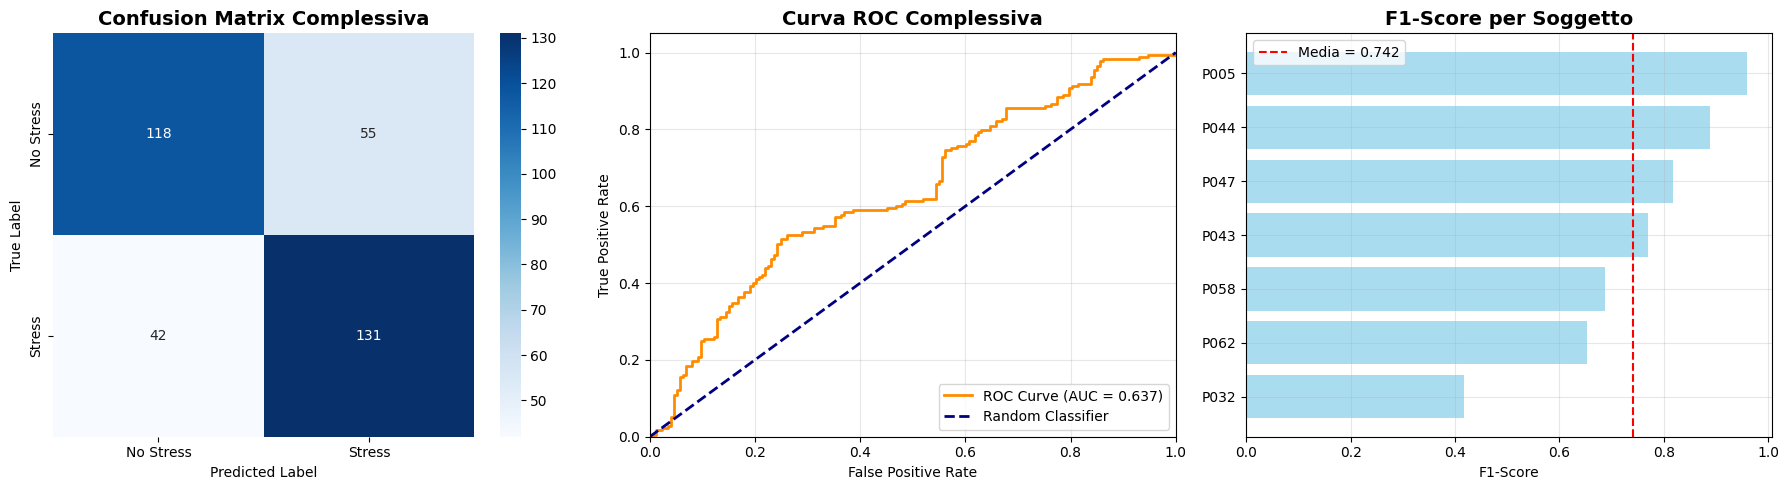


--------------------------------------------------
STATISTICHE FINALI
--------------------------------------------------
Risultati per soggetto:
subject  n_samples  accuracy  precision  recall  f1_score
   P005         26    0.9615     1.0000  0.9231    0.9600
   P032         36    0.6111     0.8333  0.2778    0.4167
   P043         32    0.7188     0.6522  0.9375    0.7692
   P044         18    0.8889     0.8889  0.8889    0.8889
   P047         74    0.7838     0.7059  0.9730    0.8182
   P058         56    0.6250     0.5897  0.8214    0.6866
   P062        104    0.6731     0.6957  0.6154    0.6531

Statistiche aggregate:
F1-Score medio: 0.7418 ± 0.1791
Accuracy media: 0.7517 ± 0.1335
Precision media: 0.7665 ± 0.1455
Recall medio: 0.7767 ± 0.2501

Range performance:
F1-Score: 0.4167 - 0.9600
Miglior soggetto: P005 (F1=0.9600)
Peggiore soggetto: P032 (F1=0.4167)

CICLO LOSO COMPLETATO!


In [ ]:
# =============================================================================
# CICLO LOSO COMPLETO CON RACCOLTA METRICHE PER VALUTAZIONE
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                           auc, accuracy_score, precision_score, recall_score, f1_score)
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# === SETUP PATH ===
save_dir = "/content/drive/MyDrive/VerBIO_Public/CNN RESULTS/45SEC-75OL"
os.makedirs(save_dir, exist_ok=True)
results_file = os.path.join(save_dir, "loso_results.csv")

best_model_dir = "/content/drive/MyDrive/CNN CROSS TEST/BEST MODELS/VERBIO"
os.makedirs(best_model_dir, exist_ok=True)

# === CARICA PROGRESSI SE ESISTENTI ===
if os.path.exists(results_file):
    results_df = pd.read_csv(results_file)
    completed_subjects = set(results_df['subject'])
else:
    results_df = pd.DataFrame()
    completed_subjects = set()

# === INIZIALIZZAZIONE VARIABILI PER RACCOLTA METRICHE ===
reports = []
best_f1_score = 0
best_model_info = None

# VARIABILI PER METRICHE AGGREGATE
all_y_true_global = []      # Tutte le label vere
all_y_pred_global = []      # Tutte le predizioni
all_y_proba_global = []     # Tutte le probabilità
all_subjects_global = []    # Soggetti corrispondenti
fold_results = []           # Risultati dettagliati per fold

print("=== INIZIO CICLO LOSO CON RACCOLTA METRICHE ===")

# === CICLO LOSO PRINCIPALE ===
for fold, (train_idx, test_idx) in enumerate(logo.split(X_dict[segnali[0]], y, groups)):
    subject_name = groups[test_idx[0]]

    if subject_name in completed_subjects:
        print(f"== Fold {fold+1} - {subject_name} già completato, salto ==")
        continue

    print(f"\n{'='*50}")
    print(f"FOLD {fold+1} - SOGGETTO: {subject_name}")
    print(f"{'='*50}")

    # === PREPARAZIONE DATI ===
    train_inputs = []
    test_inputs = []
    scalers = []

    for seg in segnali:
        X_seg = X_dict[seg]
        X_train_seg = X_seg[train_idx]
        X_test_seg = X_seg[test_idx]

        N_train, T = X_train_seg.shape[:2]
        N_test = X_test_seg.shape[0]
        X_train_flat = X_train_seg.reshape(N_train, T)
        X_test_flat = X_test_seg.reshape(N_test, T)

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_flat)
        X_test_scaled = scaler.transform(X_test_flat)

        scalers.append(scaler)
        train_inputs.append(X_train_scaled[..., np.newaxis])
        test_inputs.append(X_test_scaled[..., np.newaxis])

    y_train = y[train_idx]
    y_test = y[test_idx]

    # === VERIFICA BILANCIAMENTO ===
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)

    print(f"Train distribution: {dict(zip(unique_train, counts_train))}")
    print(f"Test distribution: {dict(zip(unique_test, counts_test))}")

    # Skip se il test set ha una sola classe
    if len(unique_test) < 2:
        print(f"[SKIP] Test set ha una sola classe per {subject_name}")
        continue

    # === CALCOLA CLASS WEIGHTS ===
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    print(f"Class weights: {class_weight_dict}")

    # === COSTRUISCI E COMPILA MODELLO ===
    model = build_cnn_model(input_shape=(2880, 1), n_signals=len(segnali))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )

    # === CALLBACKS ===
    early_stopper = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )

    checkpoint_path = os.path.join(save_dir, f"best_model_fold{fold+1}_{subject_name}.h5")
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # === ADDESTRAMENTO ===
    print("Inizio training...")
    try:
        history = model.fit(
            train_inputs, y_train,
            validation_data=(test_inputs, y_test),
            epochs=50,
            batch_size=16,
            class_weight=class_weight_dict,
            callbacks=[early_stopper, lr_scheduler, checkpoint],
            verbose=1
        )
    except Exception as e:
        print(f"[ERROR] Training fallito per {subject_name}: {e}")
        continue

    # === CARICA MIGLIOR MODELLO ===
    try:
        model.load_weights(checkpoint_path)
    except Exception as e:
        print(f"[ERROR] Impossibile caricare weights per {subject_name}: {e}")
        continue

    # === PREDIZIONE ===
    print("Predizione e valutazione...")
    try:
        y_pred_proba = model.predict(test_inputs, verbose=0)

        if len(y_pred_proba.shape) > 1:
            y_pred_proba = y_pred_proba.flatten()

        # Trova soglia ottimale
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        y_pred = (y_pred_proba > optimal_threshold).astype(int)

    except Exception as e:
        print(f"[ERROR] Predizione fallita per {subject_name}: {e}")
        continue

    # === CALCOLO METRICHE INDIVIDUALI ===
    try:
        acc = float(accuracy_score(y_test, y_pred))
        prec = float(precision_score(y_test, y_pred, zero_division=0))
        rec = float(recall_score(y_test, y_pred, zero_division=0))
        f1 = float(f1_score(y_test, y_pred, zero_division=0))
        optimal_threshold = float(optimal_threshold)

    except Exception as e:
        print(f"[ERROR] Calcolo metriche fallito per {subject_name}: {e}")
        continue

    # === STAMPA RISULTATI INDIVIDUALI ===
    print(f"\n--- RISULTATI FOLD {fold+1} - {subject_name} ---")
    print(f"Soglia ottimale: {optimal_threshold:.3f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # === CLASSIFICATION REPORT PER SOGGETTO ===
    print(f"\n--- CLASSIFICATION REPORT - {subject_name} ---")
    try:
        print(classification_report(y_test, y_pred, zero_division=0,
                                  target_names=['No Stress', 'Stress']))

        print(f"\n--- CONFUSION MATRIX - {subject_name} ---")
        cm_individual = confusion_matrix(y_test, y_pred)
        print(cm_individual)

    except Exception as e:
        print(f"[WARNING] Report dettagliato fallito: {e}")

    # === ACCUMULA DATI PER METRICHE GLOBALI ===
    all_y_true_global.extend(y_test)
    all_y_pred_global.extend(y_pred)
    all_y_proba_global.extend(y_pred_proba)
    all_subjects_global.extend([subject_name] * len(y_test))

    # === SALVA DETTAGLI FOLD ===
    fold_results.append({
        'fold': fold + 1,
        'subject': subject_name,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'optimal_threshold': optimal_threshold,
        'class_0_count': int(np.sum(y_test == 0)),
        'class_1_count': int(np.sum(y_test == 1))
    })

    # === VERIFICA MIGLIOR MODELLO ===
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_info = {
            'fold': int(fold + 1),
            'subject': str(subject_name),
            'f1_score': float(f1),
            'accuracy': float(acc),
            'precision': float(prec),
            'recall': float(rec),
            'optimal_threshold': float(optimal_threshold),
            'model_path': str(checkpoint_path),
            'scalers': scalers.copy()
        }
        print(f"*** NUOVO MIGLIOR MODELLO: F1={f1:.4f} ***")

    # === SALVA RISULTATI ===
    result_row = {
        'subject': str(subject_name),
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1_score': float(f1),
        'optimal_threshold': float(optimal_threshold)
    }

    reports.append(result_row)

    try:
        pd.DataFrame([result_row]).to_csv(
            results_file,
            mode='a',
            index=False,
            header=not os.path.exists(results_file)
        )
        print(f"Risultati salvati per {subject_name}")
    except Exception as e:
        print(f"[WARNING] Salvataggio CSV fallito per {subject_name}: {e}")

    # === PULIZIA MEMORIA ===
    try:
        del model, history, y_pred_proba, y_pred
        tf.keras.backend.clear_session()
    except:
        pass

# === SALVA MIGLIOR MODELLO ===
if best_model_info is not None:
    print(f"\n=== SALVATAGGIO MIGLIOR MODELLO ===")
    print(f"Miglior F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

    try:
        best_model = build_cnn_model(input_shape=(2880, 1), n_signals=len(segnali))
        best_model.load_weights(best_model_info['model_path'])

        best_model_path = os.path.join(best_model_dir, "best_model.keras")
        best_model.save(best_model_path)

        import joblib
        scalers_path = os.path.join(best_model_dir, "scalers.pkl")
        joblib.dump(best_model_info['scalers'], scalers_path)

        best_info_path = os.path.join(best_model_dir, "best_model_info.json")
        import json

        model_info = {
            'fold': best_model_info['fold'],
            'subject': best_model_info['subject'],
            'f1_score': best_model_info['f1_score'],
            'accuracy': best_model_info['accuracy'],
            'precision': best_model_info['precision'],
            'recall': best_model_info['recall'],
            'optimal_threshold': best_model_info['optimal_threshold']
        }

        with open(best_info_path, 'w') as f:
            json.dump(model_info, f, indent=2)

        print(f"Miglior modello salvato in: {best_model_path}")
        print(f"Scaler salvati in: {scalers_path}")
        print(f"Informazioni salvate in: {best_info_path}")

    except Exception as e:
        print(f"[ERROR] Salvataggio miglior modello fallito: {e}")

# =============================================================================
# VISUALIZZAZIONE METRICHE AGGREGATE
# =============================================================================

print(f"\n{'='*70}")
print("VALUTAZIONE COMPLESSIVA CICLO LOSO")
print(f"{'='*70}")

# Converti in array numpy
all_y_true_global = np.array(all_y_true_global)
all_y_pred_global = np.array(all_y_pred_global)
all_y_proba_global = np.array(all_y_proba_global)

print(f"Campioni totali raccolti: {len(all_y_true_global)}")
print(f"Soggetti processati: {len(fold_results)}")
print(f"Distribuzione classi globale: No Stress={np.sum(all_y_true_global == 0)}, Stress={np.sum(all_y_true_global == 1)}")

# === 1. CLASSIFICATION REPORT COMPLESSIVO ===
print(f"\n{'-'*50}")
print("CLASSIFICATION REPORT COMPLESSIVO")
print(f"{'-'*50}")

if len(all_y_true_global) > 0:
    global_report = classification_report(
        all_y_true_global, all_y_pred_global,
        zero_division=0,
        target_names=['No Stress', 'Stress']
    )
    print(global_report)
else:
    print("[WARNING] Nessun dato disponibile per il report globale")

# === 2. CONFUSION MATRIX COMPLESSIVA ===
print(f"\n{'-'*50}")
print("CONFUSION MATRIX COMPLESSIVA")
print(f"{'-'*50}")

if len(all_y_true_global) > 0:
    cm_global = confusion_matrix(all_y_true_global, all_y_pred_global)
    print("Confusion Matrix (Counts):")
    print(cm_global)

    # Percentuali
    cm_percent = cm_global.astype('float') / cm_global.sum(axis=1)[:, np.newaxis] * 100
    print("\nConfusion Matrix (Percentages):")
    print(f"[[{cm_percent[0,0]:.1f}% {cm_percent[0,1]:.1f}%]")
    print(f" [{cm_percent[1,0]:.1f}% {cm_percent[1,1]:.1f}%]]")

    # Visualizzazione grafica
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion Matrix
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0])
    axes[0].set_title('Confusion Matrix Complessiva', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # === 3. CURVA ROC COMPLESSIVA ===
    fpr, tpr, _ = roc_curve(all_y_true_global, all_y_proba_global)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Curva ROC Complessiva', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    print(f"\n{'-'*50}")
    print("CURVA ROC COMPLESSIVA")
    print(f"{'-'*50}")
    print(f"AUC (Area Under Curve): {roc_auc:.4f}")

    # === 4. PERFORMANCE PER SOGGETTO ===
    if fold_results:
        fold_df = pd.DataFrame(fold_results)
        fold_df_sorted = fold_df.sort_values('f1_score', ascending=True)

        axes[2].barh(fold_df_sorted['subject'], fold_df_sorted['f1_score'],
                     color='skyblue', alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3)

        # Aggiungi linea media
        mean_f1 = fold_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1, color='red', linestyle='--',
                        label=f'Media = {mean_f1:.3f}')
        axes[2].legend()

    plt.tight_layout()
    plt.show()

# === STATISTICHE FINALI ===
print(f"\n{'-'*50}")
print("STATISTICHE FINALI")
print(f"{'-'*50}")

if fold_results:
    fold_df = pd.DataFrame(fold_results)

    print("Risultati per soggetto:")
    print(fold_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(index=False, float_format='%.4f'))

    print(f"\nStatistiche aggregate:")
    print(f"F1-Score medio: {fold_df['f1_score'].mean():.4f} ± {fold_df['f1_score'].std():.4f}")
    print(f"Accuracy media: {fold_df['accuracy'].mean():.4f} ± {fold_df['accuracy'].std():.4f}")
    print(f"Precision media: {fold_df['precision'].mean():.4f} ± {fold_df['precision'].std():.4f}")
    print(f"Recall medio: {fold_df['recall'].mean():.4f} ± {fold_df['recall'].std():.4f}")

    print(f"\nRange performance:")
    print(f"F1-Score: {fold_df['f1_score'].min():.4f} - {fold_df['f1_score'].max():.4f}")
    print(f"Miglior soggetto: {fold_df.loc[fold_df['f1_score'].idxmax(), 'subject']} (F1={fold_df['f1_score'].max():.4f})")
    print(f"Peggiore soggetto: {fold_df.loc[fold_df['f1_score'].idxmin(), 'subject']} (F1={fold_df['f1_score'].min():.4f})")

print(f"\n{'='*70}")
print("CICLO LOSO COMPLETATO!")
print(f"{'='*70}")